# Load packages and Protein data

In [1]:
library(broom)
library(scales)
library(stringr)
library(arrow)
library(survival)
library(tidyr)
library(dplyr)
library(haven)
library(reshape2)
library(tidyverse)
library(data.table)
library(lubridate)
library(ggplot2)

Warning message:
“package ‘arrow’ was built under R version 4.4.1”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ purrr     1.0.4
✔ ggplot2   3.5.1     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor()   masks scales::col_factor()
✖ purrr::discard()      masks scales::discard()
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conf

In [2]:
#gp protein
score_kz <- fread("sscore1206_All_combined.csv")

In [3]:
dim(score_kz)

[1] 487409   2074

In [4]:
score_kz$il17ra_333 <- 2
score_kz$il17ra_333[score_kz$Interleukin17_receptor_A >= quantile(score_kz$Interleukin17_receptor_A,2/3)] <- 3
score_kz$il17ra_333[score_kz$Interleukin17_receptor_A < quantile(score_kz$Interleukin17_receptor_A,1/3)] <- 1
score_kz$il17ra_333<-as.factor(score_kz$il17ra_333)
table(score_kz$il17ra_333)


     1      2      3 
162470 162469 162470 

In [37]:
#UKB data
data_all_pheno_cox2 <- fread("data_all_pheno_coxUKB.tsv")

In [24]:
#Formula-logistic regression
batch_logistic_regression <- function(data, snp_list, outcome, covariates = NULL) {
  results <- list()
  
  base_formula <- paste0(outcome, " ~ ")
  
  for (snp in snp_list) {
    if (!is.null(covariates) && length(covariates) > 0) {
      formula <- as.formula(paste0(base_formula, snp, " + ", paste(covariates, collapse = " + ")))
    } else {
      formula <- as.formula(paste0(base_formula, snp))
    }
    

    print(formula)
    
    tryCatch({
      logistic_model <- glm(formula, data = data, family = binomial)
      summary_model <- summary(logistic_model)
      
      coef <- summary_model$coefficients[snp, "Estimate"]
      se <- summary_model$coefficients[snp, "Std. Error"]
      p_value <- summary_model$coefficients[snp, "Pr(>|z|)"]
      ci_lower <- exp(coef - 1.96 * se)
      ci_upper <- exp(coef + 1.96 * se)
      or <- exp(coef)
      
      results[[snp]] <- data.frame(
        SNP = snp,
        Beta = coef,
        OR = or,
        SE = se,
        CI_Lower = ci_lower,
        CI_Upper = ci_upper,
        P_Value = p_value
      )
    }, error = function(e) {
      warning(paste("Error in model for SNP:", snp, "- Skipping."))
    })
  }
  
  results_df <- do.call(rbind, results)
  return(results_df)
}

In [25]:
#Formula-Cox regression
analyze_cox_model <- function(data, time_var, event_var, group_var, covariates) {
  df_filtered <- data %>% filter(.data[[time_var]] > 0)
  if (nrow(df_filtered) != length(df_filtered[[time_var]]) || 
      nrow(df_filtered) != length(df_filtered[[event_var]])) {
    stop("Time and status are different lengths after filtering. Please check your data.")
  }
  
  if (!all(unique(df_filtered[[event_var]]) %in% c(0, 1))) {
    stop("Event variable must be binary (0 or 1).")
  }

  surv_obj <- Surv(time = df_filtered[[time_var]], event = df_filtered[[event_var]] == 1)
  
  covariate_formula <- paste(covariates, collapse = " + ")
  formula <- as.formula(paste("surv_obj ~", group_var, "+", covariate_formula))
  
  cox_fit <- coxph(formula, data = df_filtered)
  
  summary_cox <- summary(cox_fit)
  print(summary_cox)
  
  results <- as.data.frame(summary_cox$coefficients)
  colnames(results) <- c("Coefficient", "Exp(Coefficient)", "Standard Error", "z value", "p value")
  print(results)
  
  return(results)
}
analyze_cox_model0 <- function(data, time_var, event_var, group_var, covariates) {
  df_filtered <- data %>% filter(.data[[time_var]] > 0)
  df_filtered <- df_filtered %>% drop_na(all_of(covariates))
  surv_obj <- Surv(time = df_filtered[[time_var]], event = df_filtered[[event_var]] == 1)
  covariate_formula <- paste(covariates, collapse = " + ")
  formula <- as.formula(paste("surv_obj ~", group_var, "+", covariate_formula))
  cox_fit <- coxph(formula, data = df_filtered)
  summary_cox <- summary(cox_fit)
  print(summary_cox)
  results <- summary_cox$coefficients
  colnames(results) <- c("Coefficient", "Exp(Coefficient)", "Standard Error", "z value", "p value")
  print(results)
}

In [38]:
pro_list <- colnames(score_kz)[-1]

In [82]:
summary(score_kz$Interleukin17_receptor_A)
summary(score_kz$Interleukin17A)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.1118  0.3515  0.9603  0.9670  1.5682  3.7822 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.8318  0.8318  0.8067  0.8318  0.8318 

# CHIP data

In [40]:
calls_chip <- fread('All_CHIP_calls_for_UKB_March112024.txt') #17026

In [41]:
x <- load("Users_Kun_Zhao_vumc_id_ukb.Rdata")
x

[1] "vumc_id"

In [42]:
calls_chip <- merge(calls_chip,vumc_id, by.x = "ID", by.y = "ID_Broad", all.x = T)

In [43]:
table(data_all_pheno_cox2$chip)


     0      1 
486474  15939 

In [46]:
data_chip <- filter(data_all_pheno_cox2, data_all_pheno_cox2$chip==1)

In [47]:
data_chip$CVD <- NA
data_chip$CVD <- ifelse(data_chip$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_chip$`Myocardial infarction [Heart attack]`==1 |
                        data_chip$Stroke==1|
                        data_chip$`Heart failure`==1|
                        data_chip$`Angina pectoris`==1|
                        data_chip$`Peripheral vascular disease`==1,1, 0)
table(data_chip$CVD)


    0     1 
14984   955 

In [48]:
data_chip$ASCVD <- NA
data_chip$ASCVD <- ifelse(data_chip$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_chip$`Myocardial infarction [Heart attack]`==1 |
                        data_chip$`Heart failure`==1|
                        data_chip$`Angina pectoris`==1|
                        data_chip$`Peripheral vascular disease`==1,1, 0)
table(data_chip$ASCVD)


    0     1 
15135   804 

In [49]:
data_chip$CAD <- NA
data_chip$CAD <- ifelse(data_chip$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_chip$`Myocardial infarction [Heart attack]`==1 |
                        data_chip$`Angina pectoris`==1,1, 0)

In [50]:
data_chip$AML <- NA
data_chip$AML <- ifelse(data_chip$`Acute myeloid leukemia`==1|
                        data_chip$`Myelodysplastic syndrome`==1 |
                        data_chip$Myelofibrosis==1|
                        data_chip$`Myeloproliferative disorder`==1|
                        data_chip$`Polycythemia vera`==1|
                        data_chip$`Essential thrombocythemia`==1,1, 0)

In [51]:
data_chip$AID <- NA
data_chip$AID <- ifelse(data_chip$`Rheumatoid arthritis`==1|
                        data_chip$`Ankylosing spondylitis`==1 |
                        data_chip$`Systemic lupus erythematosus [SLE]`==1|
                        data_chip$Psoriasis==1|
                        data_chip$`Psoriatic arthropathy`==1,1, 0)
table(data_chip$AID)


    0     1 
15569   370 

In [52]:
data_chip$VTE <- NA
data_chip$VTE <- ifelse(data_chip$`Pulmonary embolism`==1|
                        data_chip$`Venous thromboembolism`==1 ,1, 0)

In [53]:
data_chip$MPN <- NA
data_chip$MPN <- ifelse(data_chip$`Myeloproliferative disorder`==1|
                        data_chip$VTE==1 |
                        data_chip$`Chronic myeloproliferative disease*` == 1 ,1, 0)

In [54]:
data_chip2 <- data_chip[,c("ID_VUMC","baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_HTN","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0",
                          "Acute myeloid leukemia","Heart failure","AML","ASCVD","CVD","CAD","Myocardial infarction [Heart attack]","Stroke", "Thrombosis of cerebral or precerebral arteries","Venous thromboembolism","VTE","death","AID",
                          "Rheumatoid arthritis","Ankylosing spondylitis","Systemic lupus erythematosus [SLE]","Psoriasis","Psoriatic arthropathy","Myeloproliferative disorder", "MPN","Chronic myeloproliferative disease*","Peripheral vascular disease")]

In [55]:
score_kz$ID <- as.character(score_kz$ID)
data_chip2$ID_VUMC <- as.character(data_chip2$ID_VUMC)

In [56]:
data_chip_protein <- merge(data_chip2, score_kz, by.x = "ID_VUMC" , by.y = "ID", all.x = T)

In [57]:
dim(data_chip_protein)

[1] 15939  2111

# gIL17RA & CVD

## Overall CHIP

In [41]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0")
)
logistic_mca

CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    systolicBP_0 + diastolicBP_0 + ldl_0
<environment: 0x59676c5eda68>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.0712689,0.9312115,0.04523343,0.8522065,1.017541,0.1151226


In [42]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "ASCVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0")
)
logistic_mca

ASCVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    systolicBP_0 + diastolicBP_0 + ldl_0
<environment: 0x5969bddae990>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.07106488,0.9314015,0.0492088,0.8457647,1.025709,0.1486969


In [43]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CAD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0")
)
logistic_mca

CAD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    systolicBP_0 + diastolicBP_0 + ldl_0
<environment: 0x59696ec360b0>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.04756861,0.953545,0.05860188,0.850077,1.069607,0.4169494


In [44]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "Stroke",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0")
)
logistic_mca

Stroke ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    systolicBP_0 + diastolicBP_0 + ldl_0
<environment: 0x5968d20a89a0>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.02116689,0.9790556,0.09342895,0.8152279,1.175806,0.820769


In [45]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Heart failure`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0")
)
logistic_mca

`Heart failure` ~ Interleukin17_receptor_A + baseline_age + age2 + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    BMI_0 + baseline_DM + systolicBP_0 + diastolicBP_0 + ldl_0
<environment: 0x596b947bf6d8>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,0.09180221,1.096148,0.1072291,0.8883702,1.352522,0.3919249


In [62]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_protein,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Peripheral vascular disease`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

`Peripheral vascular disease` ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + BMI_0 + baseline_DM + baseline_HTN + ldl_0 + AID
<environment: 0x5968bfc36c20>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.1518247,0.8591389,0.08818832,0.7227631,1.021247,0.08514275


## JAK2-CHIP

In [44]:
d3a <- filter(calls_chip, calls_chip$Gene.refGene == "DNMT3A")
tet2 <-filter(calls_chip, calls_chip$Gene.refGene == "TET2")
jak2 <-filter(calls_chip, calls_chip$Gene.refGene == "JAK2")

In [58]:
data_chip_protein$d3a <- ifelse(data_chip_protein$ID_VUMC %in% d3a$ID_VUMC , 1, 0)
data_chip_protein$tet2 <- ifelse(data_chip_protein$ID_VUMC %in% tet2$ID_VUMC , 1, 0)
data_chip_protein$jak2 <- ifelse(data_chip_protein$ID_VUMC %in% jak2$ID_VUMC , 1, 0)

In [59]:
data_jak2 <- filter(data_chip_protein, data_chip_protein$jak2 == 1)

In [60]:
table(data_jak2$`Heart failure`, useNA= "always")
table(data_jak2$`Myocardial infarction [Heart attack]`, useNA= "always")
table(data_jak2$`Peripheral vascular disease`, useNA= "always")


   0    1 <NA> 
 187    5    0 


   0    1 <NA> 
 185    7    0 


   0    1 <NA> 
 185    7    0 

In [133]:
#save jak2 only data (192 ppl)
save(data_jak2, file = "data_jak2_192_UKB.Rdata")

In [5]:
x <- load("data_jak2_192_UKB.Rdata")
x

[1] "data_jak2"

In [46]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID
<environment: 0x596b93b128e8>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-1.533325,0.215817,0.4867763,0.0831253,0.5603224,0.001632944


In [47]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "ASCVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

ASCVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID
<environment: 0x59677857fb90>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-1.896671,0.1500673,0.5512984,0.05093442,0.4421409,0.0005809152


In [48]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CAD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

CAD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID
<environment: 0x5967758f36c8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-2.797349,0.06097151,0.9568266,0.00934673,0.3977353,0.003460435


In [49]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "Stroke",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

Stroke ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID
<environment: 0x59676f4bfdc8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-1.176304,0.3084166,1.02219,0.04159412,2.286881,0.2498277


In [83]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Heart failure`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","baseline_DM","baseline_HTN")
)
logistic_mca

`Heart failure` ~ Interleukin17_receptor_A + baseline_age + age2 + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    baseline_DM + baseline_HTN
<environment: 0x5a5443e3b4f0>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-1.400961,0.2463602,0.8514316,0.046432,1.307145,0.0998837


In [51]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Myocardial infarction [Heart attack]`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

`Myocardial infarction [Heart attack]` ~ Interleukin17_receptor_A + 
    baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + 
    PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + baseline_HTN + ldl_0 + 
    AID
<environment: 0x596ba86d42b8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-2.983787,0.05060086,1.439244,0.003013344,0.8497028,0.03815715


In [61]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Peripheral vascular disease`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

`Peripheral vascular disease` ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + BMI_0 + baseline_DM + baseline_HTN + ldl_0 + AID
<environment: 0x5969b00383a8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.8021389,0.4483689,0.7466922,0.103762,1.93746,0.2827077


## Change 3.2 to Firth logistic

In [122]:
library(logistf)
library(dplyr)

run_firth_logistic <- function(data, outcome, exposure, covariates) {
  formula_str <- paste(outcome, "~", paste(c(exposure, covariates), collapse = " + "))
  fml <- as.formula(formula_str)

  tryCatch({
    fit <- logistf(
      fml, data = data,
      control = logistf.control(maxit = 1000, maxstep = 5),
      plcontrol = logistpl.control(maxit = 1000)
    )

    if (!exposure %in% names(fit$coefficients)) {
      stop("Exposure not found in model.")
    }

    coef <- fit$coefficients[exposure]
    se <- if (!is.null(dimnames(fit$var))) sqrt(fit$var[exposure, exposure]) else NA
    ci <- tryCatch(exp(confint(fit)[exposure, ]), error = function(e) c(NA, NA))
    or <- exp(coef)
    p <- fit$prob[exposure]

    N_total <- nrow(data)
    N_event <- sum(data[[outcome]] == 1, na.rm = TRUE)

    tibble(
      Variable = exposure,
      N = N_total,
      Nevent = N_event,
      OR = round(or, 2),
      CI_Lower = round(ci[1], 2),
      CI_Upper = round(ci[2], 2),
      P_Value = signif(p, 3)
    )
  }, error = function(e) {
    warning(paste("Error with variable:", exposure, "-", e$message))
    tibble(
      Variable = exposure,
      N = nrow(data),
      Nevent = sum(data[[outcome]] == 1, na.rm = TRUE),
      OR = NA,
      CI_Lower = NA,
      CI_Upper = NA,
      P_Value = NA
    )
  })
}

In [123]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "CVD",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM", "ldl_0", "AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192     21  0.38     0.17     0.77 0.00671


In [105]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "CVD",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM", "ldl_0", "AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192     21  0.38     0.17     0.77 0.00671


In [124]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "ASCVD",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN", "baseline_DM", "ldl_0", "AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192     20  0.31     0.13     0.65 0.00166


In [125]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "CAD",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM", "ldl_0", "AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192     13   0.3      0.1     0.75   0.009


In [126]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "Stroke",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM","AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192      5  0.72     0.19     2.34   0.584


In [127]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "`Peripheral vascular disease`",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM","AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192      0  0.63      0.2     1.71   0.365


In [138]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "`Heart failure`",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM", "ldl_0","AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192      0  0.24     0.02     0.98  0.0457


In [130]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "`Heart failure`",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM", "ldl_0","AID")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192      0  0.22     0.01     1.03  0.0545


In [131]:
table(data_jak2$`Myocardial infarction [Heart attack]`)


  0   1 
185   7 

In [144]:
result <- run_firth_logistic(
  data = data_jak2,
  outcome = "`Myocardial infarction [Heart attack]`",
  exposure = "Interleukin17_receptor_A",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0",
                 "PC1", "PC2", "PC3", "PCD4", "PC5", "baseline_HTN","baseline_DM","AID", "ldl_0")
)

print(result)

# A tibble: 1 × 7
  Variable                     N Nevent    OR CI_Lower CI_Upper P_Value
  <chr>                    <int>  <int> <dbl>    <dbl>    <dbl>   <dbl>
1 Interleukin17_receptor_A   192      0  0.47     0.13      1.4   0.178


## JAK2 by VAF group

In [7]:
table(jak2$NonsynOI)
summary(jak2$AF)


V617F 
  192 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1350  0.2552  0.3330  0.4140  0.5655  0.9670 

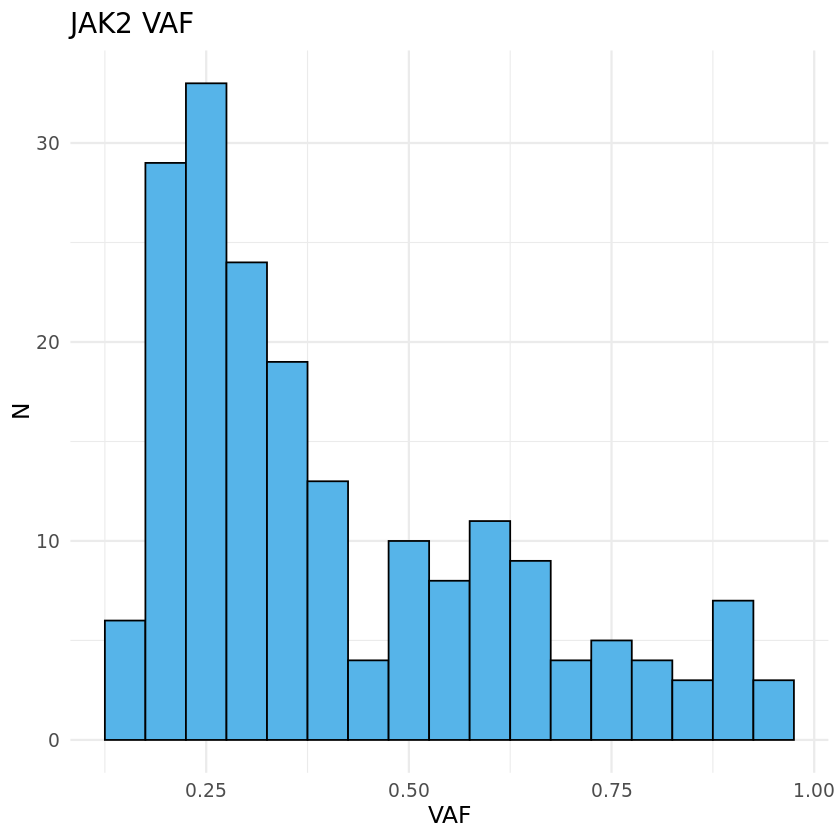

In [114]:
ggplot(jak2, aes(x = AF)) +
  geom_histogram(binwidth = 0.05, fill = "#56B4E9", color = "black") +
  labs(title = "JAK2 VAF", x = "VAF", y = "N") +
  theme_minimal(base_size = 14)

In [8]:
jak2_af <- jak2[,c("ID_VUMC","AF")]

In [9]:
jak2_af$ID_VUMC <- as.character(jak2_af$ID_VUMC)
data_jak2 <- merge(data_jak2,jak2_af, by = "ID_VUMC",all.x = T)

In [10]:
data_jak2$jak2_af333 <- 2
data_jak2$jak2_af333[data_jak2$AF >= quantile(data_jak2$AF,2/3)] <- 3
data_jak2$jak2_af333[data_jak2$AF < quantile(data_jak2$AF,1/3)] <- 1
data_jak2$jak2_af333 <- as.factor(data_jak2$jak2_af333)
table(data_jak2$jak2_af333)


 1  2  3 
62 66 64 

In [17]:
data_jak2_low <- filter(data_jak2, data_jak2$jak2_af333 == 1)
data_jak2_inter <- filter(data_jak2, data_jak2$jak2_af333 == 2)
data_jak2_high <- filter(data_jak2, data_jak2$jak2_af333 == 3)

In [65]:
table(data_jak2_low$CVD)
table(data_jak2_inter$CVD)
table(data_jak2_high$CVD)


 0  1 
52 10 


 0  1 
60  6 


 0  1 
59  5 

In [63]:
summary(data_jak2_low$AF)
summary(data_jak2_inter$AF)
summary(data_jak2_high$AF)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1350  0.1990  0.2180  0.2192  0.2500  0.2710 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2720  0.2945  0.3330  0.3401  0.3752  0.4740 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4840  0.5665  0.6355  0.6790  0.7843  0.9670 

In [13]:
library(dplyr)
library(tidyr)
library(logistf)

In [33]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age  + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5, data = data_jak2_low,
                 control = logistf.control(maxit = 1000, maxstep = 5),
                 plcontrol = logistpl.control(maxit = 1000)
)
summary(firth)

logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5, data = data_jak2_low, 
    control = logistf.control(maxit = 1000, maxstep = 5), plcontrol = logistpl.control(maxit = 1000))

Model fitted by Penalized ML
Coefficients:
                                 coef   se(coef)   lower 0.95 upper 0.95
(Intercept)              -3.689123559 4.56550027 -14.63753881 5.35201464
Interleukin17_receptor_A -0.514164784 0.44040597  -1.52611445 0.35476779
baseline_age              0.065259420 0.06870847  -0.06977242 0.22929668
genetic_sex              -0.007953038 0.65433355  -1.37938044 1.40659981
smoking_0                -0.167314672 0.61420601  -1.53238819 1.07306987
PC1                       0.120955467 0.17028613  -0.22432682 0.49494986
PC2                       0.016221800 0.15854365  -0.30761806 0.36757450
PC3                      -0.107806152 0.17671303  -0.49207453 0.25587136
PCD4                      0.005616449 0.0468041

In [32]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age  + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5, data = data_jak2_inter,
                 control = logistf.control(maxit = 1000, maxstep = 5),
                 plcontrol = logistpl.control(maxit = 1000)
)
summary(firth)

logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5, data = data_jak2_inter, 
    control = logistf.control(maxit = 1000, maxstep = 5), plcontrol = logistpl.control(maxit = 1000))

Model fitted by Penalized ML
Coefficients:
                                  coef   se(coef)   lower 0.95  upper 0.95
(Intercept)              -14.352423633 6.54130210 -37.03712294 -0.93664497
Interleukin17_receptor_A  -1.488199403 0.67680958  -3.65112730 -0.08742583
baseline_age               0.203287745 0.09564791   0.01099929  0.52252334
genetic_sex                0.442141240 0.94990451  -1.58963857  3.24361361
smoking_0                 -0.706725024 0.71980613  -2.93589659  0.79592148
PC1                       -0.110150494 0.25446590  -0.76395549  0.47160651
PC2                       -0.163325708 0.23309397  -0.77575507  0.45242894
PC3                       -0.089302858 0.21677338  -0.59447670  0.43901177
PCD4                      -

In [36]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5+baseline_HTN+ldl_0+AID, data = data_jak2_high,
                control = logistf.control(maxit = 1000, maxstep = 5),
                plcontrol = logistpl.control(maxit = 1000)
)
summary(firth)

logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    baseline_HTN + ldl_0 + AID, data = data_jak2_high, control = logistf.control(maxit = 1000, 
    maxstep = 5), plcontrol = logistpl.control(maxit = 1000))

Model fitted by Penalized ML
Coefficients:
                                coef   se(coef)    lower 0.95 upper 0.95
(Intercept)              -8.16551617 6.85395217 -77.255568236 19.8748950
Interleukin17_receptor_A -1.89601157 0.81436432  -6.297185271 -0.1722355
baseline_age              0.20233241 0.09612419   0.002944959  0.7519569
genetic_sex              -0.01750279 1.02752711  -3.227135818  3.3433193
smoking_0                 0.15332436 0.93890650  -6.491398550  3.9236035
PC1                       0.04011165 0.06872639  -0.210704230  0.8108426
PC2                      -0.15992332 0.38147706  -4.358656533  1.3465466
PC3                       0.52049758 0.41701839  -1.569207139  3.2456048
PCD4        

In [71]:
exp(-0.514164784-1.96*0.44040597)
exp(-1.488199403+1.96*0.67680958)
exp(-1.89594301+1.96*0.81436432)

[1] 0.2522435

[1] 0.8507367

[1] 0.7409746

In [ ]:
#VAF by 262

In [11]:
data_jak2$jak2_af262 <- 2
data_jak2$jak2_af262[data_jak2$AF >= quantile(data_jak2$AF,0.8)] <- 3
data_jak2$jak2_af262[data_jak2$AF < quantile(data_jak2$AF,0.2)] <- 1
data_jak2$jak2_af262 <- as.factor(data_jak2$jak2_af262)
table(data_jak2$jak2_af262)


  1   2   3 
 38 115  39 

In [12]:
data_jak2_low <- filter(data_jak2, data_jak2$jak2_af262 == 1)
data_jak2_inter <- filter(data_jak2, data_jak2$jak2_af262 == 2)
data_jak2_high <- filter(data_jak2, data_jak2$jak2_af262 == 3)

In [14]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5+baseline_HTN+ldl_0+AID, data = data_jak2_low)
summary(firth)

Warning message in logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + :
“logistf.fit: Maximum number of iterations for full model exceeded. Try to increase the number of iterations or alter step size by passing 'logistf.control(maxit=..., maxstep=...)' to parameter control”
Warning message in logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + :
“Nonconverged PL confidence limits: maximum number of iterations for variables: (Intercept), baseline_age, age2 exceeded. Try to increase the number of iterations by passing 'logistpl.control(maxit=...)' to parameter plcontrol”


logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + baseline_HTN + ldl_0 + AID, data = data_jak2_low)

Model fitted by Penalized ML
Coefficients:
                                  coef     se(coef)    lower 0.95   upper 0.95
(Intercept)              -33.291828568 113.18386798 -527.23230856 229.67907182
Interleukin17_receptor_A  -0.252729351   0.78578646   -2.82178947   1.61621774
baseline_age               0.757492769   3.78736179   -8.18437660  17.07429307
age2                      -0.004071738   0.03126989   -0.13660214   0.07019698
genetic_sex               -0.367609337   0.99170690   -2.89728625   2.39673946
smoking_0                 -0.697708651   0.88993916   -3.18783719   1.33492939
PC1                        0.436801932   0.24675436   -0.12471080   1.30544748
PC2                        0.583408579   0.31498823   -0.17971529   1.70473235
PC3                        0.204035481   0.26393781   -

In [15]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5+baseline_HTN+ldl_0+AID, data = data_jak2_inter)
summary(firth)

logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + baseline_HTN + ldl_0 + AID, data = data_jak2_inter)

Model fitted by Penalized ML
Coefficients:
                                  coef     se(coef)   lower 0.95  upper 0.95
(Intercept)              -14.179194428 22.426510692 -74.49456019 33.21034723
Interleukin17_receptor_A  -0.609671319  0.511998873  -1.85969955  0.60756280
baseline_age               0.496333346  0.774973059  -1.15776014  2.53762435
age2                      -0.003517236  0.006661667  -0.02072486  0.01083867
genetic_sex               -1.258598655  0.754078856  -3.25860346  0.39688911
smoking_0                  0.251159964  0.618573875  -1.31368409  1.71320796
PC1                        0.126420985  0.184191613  -0.30881977  0.59347624
PC2                       -0.068803492  0.157139156  -0.48788609  0.28615415
PC3                       -0.178991371  0.201553160  -0.68739774  0.296

In [16]:
firth <- logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5+baseline_HTN+ldl_0+AID, data = data_jak2_high)
summary(firth)

Warning message in logistf(CVD ~ Interleukin17_receptor_A + baseline_age + age2 + :
“logistf.fit: Maximum number of iterations for full model exceeded. Try to increase the number of iterations or alter step size by passing 'logistf.control(maxit=..., maxstep=...)' to parameter control”


logistf(formula = CVD ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + baseline_HTN + ldl_0 + AID, data = data_jak2_high)

Model fitted by Penalized ML
Coefficients:
                                coef    se(coef)    lower 0.95   upper 0.95
(Intercept)              36.74555176 53.12093492 -268.01599512 237.81960323
Interleukin17_receptor_A -0.93151901  0.69434901   -4.32234560   0.55210810
baseline_age             -1.33220372  1.84984171   -8.64066489   8.28199018
age2                      0.01225809  0.01548323   -0.06277983   0.07586344
genetic_sex               0.79118614  1.37630122   -3.46994617   7.76295167
smoking_0                 0.14514263  0.82193489   -3.32223706   3.79422959
PC1                       0.07878984  0.07051770   -0.10600337   0.52595945
PC2                      -0.39610932  0.38647858   -2.84373114   0.71927442
PC3                       0.28069286  0.32071505   -1.05561493   1.47241328
PCD4 

## All ppl

In [83]:
data_all_pheno_cox2$CVD <- NA
data_all_pheno_cox2$CVD <- ifelse(data_all_pheno_cox2$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_all_pheno_cox2$`Myocardial infarction [Heart attack]`==1 |
                        data_all_pheno_cox2$Stroke==1|
                        data_all_pheno_cox2$`Heart failure`==1|
                        data_all_pheno_cox2$`Angina pectoris`==1|
                        data_all_pheno_cox2$`Peripheral vascular disease`==1,1, 0)
data_all_pheno_cox2$CVD <- ifelse(is.na(data_all_pheno_cox2$CVD),0,data_all_pheno_cox2$CVD)

In [86]:
data_all_pheno_cox2$ASCVD <- NA
data_all_pheno_cox2$ASCVD <- ifelse(data_all_pheno_cox2$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_all_pheno_cox2$`Myocardial infarction [Heart attack]`==1 |
                        data_all_pheno_cox2$`Heart failure`==1|
                        data_all_pheno_cox2$`Angina pectoris`==1|
                        data_all_pheno_cox2$`Peripheral vascular disease`==1,1, 0)
table(data_all_pheno_cox2$ASCVD)


     0      1 
484186  18227 

In [87]:
data_all_pheno_cox2$CAD <- NA
data_all_pheno_cox2$CAD <- ifelse(data_all_pheno_cox2$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_all_pheno_cox2$`Myocardial infarction [Heart attack]`==1 |
                        data_all_pheno_cox2$`Angina pectoris`==1,1, 0)

In [84]:
data_all_pheno_cox2$AID <- NA
data_all_pheno_cox2$AID <- ifelse(data_all_pheno_cox2$`Rheumatoid arthritis`==1|
                        data_all_pheno_cox2$`Ankylosing spondylitis`==1 |
                        data_all_pheno_cox2$`Systemic lupus erythematosus [SLE]`==1|
                        data_all_pheno_cox2$Psoriasis==1|
                        data_all_pheno_cox2$`Psoriatic arthropathy`==1,1, 0)
data_all_pheno_cox2$AID <- ifelse(is.na(data_all_pheno_cox2$AID),0,data_all_pheno_cox2$AID)
table(data_all_pheno_cox2$AID, useNA = "always")


     0      1   <NA> 
491542  10871      0 

In [89]:
data_all_cvd <- data_all_pheno_cox2[,c("ID_VUMC","baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_HTN","baseline_DM","systolicBP_0","diastolicBP_0","ldl_0",
                          "Acute myeloid leukemia","Heart failure","ASCVD","CVD","CAD","Myocardial infarction [Heart attack]","Stroke", "Thrombosis of cerebral or precerebral arteries","Venous thromboembolism","death","AID",
                          "Rheumatoid arthritis","Ankylosing spondylitis","Systemic lupus erythematosus [SLE]","Psoriasis","Psoriatic arthropathy","Myeloproliferative disorder","Chronic myeloproliferative disease*","Peripheral vascular disease")]

In [91]:
table(data_all_cvd$CVD,useNA="always")


     0      1   <NA> 
480728  21685      0 

In [92]:
data_all_cvd$ID_VUMC <- as.character(data_all_cvd$ID_VUMC)

In [93]:
il17ra <- score_kz[,c("ID","Interleukin17_receptor_A")]
data_all_cvd <- merge(data_all_cvd, il17ra, by.x = "ID_VUMC" , by.y = "ID", all.x = T)

In [205]:
summary(data_all_cvd$Interleukin17_receptor_A)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -1.112   0.351   0.960   0.967   1.568   3.782   15342 

In [94]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    systolicBP_0 + diastolicBP_0 + baseline_DM + AID
<environment: 0x596777bbe2f0>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.004437138,0.9955727,0.009469385,0.9772653,1.014223,0.6393719


In [95]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "ASCVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

ASCVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    systolicBP_0 + diastolicBP_0 + baseline_DM + AID
<environment: 0x5967711ca668>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.002703851,0.9972998,0.01027403,0.9774179,1.017586,0.792417


In [96]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CAD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

CAD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    systolicBP_0 + diastolicBP_0 + baseline_DM + AID
<environment: 0x596b94821760>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.0009183841,0.999082,0.0125585,0.9747902,1.023979,0.9417039


In [97]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "Stroke",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

Stroke ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    systolicBP_0 + diastolicBP_0 + baseline_DM + AID
<environment: 0x596b9465f710>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.01300904,0.9870752,0.02030804,0.9485576,1.027157,0.5217919


In [98]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Peripheral vascular disease`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

`Peripheral vascular disease` ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + ldl_0 + BMI_0 + systolicBP_0 + diastolicBP_0 + baseline_DM + 
    AID
<environment: 0x596ba69e8e28>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.01223672,0.9878378,0.01807535,0.9534537,1.023462,0.4984161


In [99]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Myocardial infarction [Heart attack]`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

`Myocardial infarction [Heart attack]` ~ Interleukin17_receptor_A + 
    baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + 
    PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + systolicBP_0 + diastolicBP_0 + 
    baseline_DM + AID
<environment: 0x596b94071c40>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.004408549,0.9956012,0.01754757,0.9619414,1.030439,0.8016331


In [100]:
logistic_mca <- batch_logistic_regression(
  data = data_all_cvd,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Heart failure`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","systolicBP_0","diastolicBP_0","baseline_DM","AID")
)
logistic_mca

`Heart failure` ~ Interleukin17_receptor_A + baseline_age + age2 + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    ldl_0 + BMI_0 + systolicBP_0 + diastolicBP_0 + baseline_DM + 
    AID
<environment: 0x596778acfe98>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,0.005214842,1.005228,0.02581723,0.9556277,1.057404,0.8399239


## Other CHIP

In [102]:
data_chip_nonjak2 <-  filter(data_chip_protein, data_chip_protein$jak2 == 0)
table(data_chip_nonjak2$CVD, useNA= "always")


    0     1  <NA> 
14813   934     0 

In [105]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

CVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    baseline_HTN + baseline_DM + AID
<environment: 0x596776c7e048>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.0549146,0.946566,0.04621085,0.8646004,1.036302,0.2346961


In [106]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "ASCVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

ASCVD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    baseline_HTN + baseline_DM + AID
<environment: 0x596770099050>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.04663859,0.9544323,0.05025823,0.8648971,1.053236,0.3534184


In [107]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "CAD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

CAD ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    baseline_HTN + baseline_DM + AID
<environment: 0x5967748d0fa0>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.01851875,0.9816517,0.05982111,0.873045,1.103769,0.7568888


In [108]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "Stroke",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

Stroke ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + 
    baseline_HTN + baseline_DM + AID
<environment: 0x596b94389370>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.02435197,0.9759421,0.09487642,0.8103332,1.175397,0.7974332


In [109]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Myocardial infarction [Heart attack]`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

`Myocardial infarction [Heart attack]` ~ Interleukin17_receptor_A + 
    baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + 
    PC3 + PCD4 + PC5 + ldl_0 + BMI_0 + baseline_HTN + baseline_DM + 
    AID
<environment: 0x596778e59f18>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,0.008981499,1.009022,0.08395173,0.8559324,1.189493,0.9148016


In [110]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Heart failure`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

`Heart failure` ~ Interleukin17_receptor_A + baseline_age + age2 + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    ldl_0 + BMI_0 + baseline_HTN + baseline_DM + AID
<environment: 0x596777ca0610>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,0.131714,1.140782,0.1093202,0.920762,1.413377,0.2282629


In [111]:
logistic_mca <- batch_logistic_regression(
  data = data_chip_nonjak2,
  snp_list = "Interleukin17_receptor_A",
  outcome = "`Peripheral vascular disease`",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","ldl_0","BMI_0","baseline_HTN","baseline_DM","AID")
)
logistic_mca

`Peripheral vascular disease` ~ Interleukin17_receptor_A + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + ldl_0 + BMI_0 + baseline_HTN + baseline_DM + AID
<environment: 0x59677144f5b8>


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.1428871,0.8668519,0.08923068,0.7277634,1.032523,0.1093054


# JAK2 & CVD incidence

## Data organization

In [178]:
dim(data_all_pheno_cox2)

[1] 502413   4853

In [179]:
table(data_all_pheno_cox2$`Venous thromboembolism`,useNA = "always")
summary(data_all_pheno_cox2$`time_Venous thromboembolism`)
summary(data_all_pheno_cox2$min_date)
summary(data_all_pheno_cox2$max_date)


     0      1   <NA> 
489276  13137      0 

Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"1990-01-01" "2001-07-30" "2007-06-04" "2006-06-11" "2012-04-12" "2017-09-19" 
        NA's 
    "489276"

Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2006-03-13" "2008-05-22" "2009-01-26" "2009-01-22" "2009-10-06" "2010-10-01"

Min.      1st Qu.       Median         Mean      3rd Qu.         Max. 
"2006-05-10" "2021-07-21" "2021-07-21" "2021-03-06" "2021-07-21" "2021-07-21"

In [180]:
data_all_pheno_cox2$surv_VTE <- NA
data_all_pheno_cox2$surv_all <- NA
data_all_pheno_cox2$surv_VTE <- as.numeric(difftime(data_all_pheno_cox2$`time_Venous thromboembolism`, data_all_pheno_cox2$min_date, units ="days"))/365.25
data_all_pheno_cox2$surv_all <- as.numeric(difftime(data_all_pheno_cox2$max_date, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_VTE)
data_all_pheno_cox2$surv_VTE <- ifelse(is.na(data_all_pheno_cox2$surv_VTE),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_VTE)
summary(data_all_pheno_cox2$surv_VTE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -20.3    -7.4    -1.5    -2.4     3.4    10.3  489276 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.32   11.54   12.34   11.74   13.07   15.36 

In [181]:
data_all_pheno_cox2$jak2 <- ifelse(data_all_pheno_cox2$ID_VUMC %in% jak2$ID_VUMC , 1, 0)
table(data_all_pheno_cox2$jak2)


     0      1 
502221    192 

In [182]:
data_all_pheno_cox2$surv_AHD <- NA
data_all_pheno_cox2$surv_AHD <- as.numeric(difftime(data_all_pheno_cox2$`time_Coronary atherosclerosis [Atherosclerotic heart disease]`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_AHD)
data_all_pheno_cox2$surv_AHD <- ifelse(is.na(data_all_pheno_cox2$surv_AHD),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_AHD)
summary(data_all_pheno_cox2$surv_AHD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -19.1    -4.7     0.1    -0.7     4.3     9.6  500990 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -19.09   11.65   12.38   12.08   13.10   15.36 

In [183]:
data_all_pheno_cox2$surv_AMI <- NA
data_all_pheno_cox2$surv_AMI <- as.numeric(difftime(data_all_pheno_cox2$`time_Myocardial infarction [Heart attack]`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_AMI)
data_all_pheno_cox2$surv_AMI <- ifelse(is.na(data_all_pheno_cox2$surv_AMI),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_AMI)
summary(data_all_pheno_cox2$surv_AMI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -20.4    -8.2    -2.3    -2.9     3.2     9.6  496437 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.43   11.62   12.37   11.95   13.09   15.36 

In [184]:
data_all_pheno_cox2$surv_str <- NA
data_all_pheno_cox2$surv_str <- as.numeric(difftime(data_all_pheno_cox2$`time_Stroke`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_str)
data_all_pheno_cox2$surv_str <- ifelse(is.na(data_all_pheno_cox2$surv_str),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_str)
summary(data_all_pheno_cox2$surv_str)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -20.1    -4.7     1.2    -0.4     4.9     9.8  497984 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.06   11.63   12.38   12.01   13.09   15.36 

In [185]:
data_all_pheno_cox2$surv_hf <- NA
data_all_pheno_cox2$surv_hf <- as.numeric(difftime(data_all_pheno_cox2$`time_Heart failure`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_hf)
data_all_pheno_cox2$surv_hf <- ifelse(is.na(data_all_pheno_cox2$surv_hf),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_hf)
summary(data_all_pheno_cox2$surv_hf)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -19.3    -2.3     2.5     1.0     5.2     9.5  499669 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -19.34   11.64   12.38   12.06   13.10   15.36 

In [186]:
data_all_pheno_cox2$surv_AP <- NA
data_all_pheno_cox2$surv_AP <- as.numeric(difftime(data_all_pheno_cox2$`time_Angina pectoris`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_AP)
data_all_pheno_cox2$surv_AP <- ifelse(is.na(data_all_pheno_cox2$surv_AP),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_AP)
summary(data_all_pheno_cox2$surv_AP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -20.3    -8.8    -4.0    -3.8     2.1     9.8  495107 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.30   11.62   12.37   11.89   13.09   15.36 

In [187]:
data_all_pheno_cox2$surv_PVD <- NA
data_all_pheno_cox2$surv_PVD <- as.numeric(difftime(data_all_pheno_cox2$`time_Peripheral vascular disease`, data_all_pheno_cox2$min_date, units ="days"))/365.25
summary(data_all_pheno_cox2$surv_PVD)
data_all_pheno_cox2$surv_PVD <- ifelse(is.na(data_all_pheno_cox2$surv_PVD),data_all_pheno_cox2$surv_all,data_all_pheno_cox2$surv_PVD)
summary(data_all_pheno_cox2$surv_PVD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  -20.4    -6.4    -0.7    -1.9     3.5     9.7  496826 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.39   11.63   12.37   11.97   13.09   15.36 

In [188]:
data_all_pheno_cox2 <- data_all_pheno_cox2 %>% mutate(surv_CVD = pmin(surv_PVD,surv_AP,surv_hf,surv_str,surv_AMI,surv_AHD))

In [189]:
summary(data_all_pheno_cox2$surv_CVD)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -20.43   11.50   12.33   11.51   13.07   15.36 

In [191]:
data_all_pheno_cox2$jak2 <- ifelse(data_all_pheno_cox2$chip == 1 & data_all_pheno_cox2$jak2 == 0, NA, data_all_pheno_cox2$jak2)

In [192]:
table(data_all_pheno_cox2$jak2, useNA ="always")


     0      1   <NA> 
486474    192  15747 

In [22]:
x <- load("data_all_pheno_cox3_IL17R.Rdata")
x

[1] "data_all_pheno_cox3"

In [95]:
data_all_pheno_cox3$ASCVD <- NA
data_all_pheno_cox3$ASCVD <- ifelse(data_all_pheno_cox3$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_all_pheno_cox3$`Myocardial infarction [Heart attack]`==1 |
                        data_all_pheno_cox3$`Heart failure`==1|
                        data_all_pheno_cox3$`Angina pectoris`==1|
                        data_all_pheno_cox3$`Peripheral vascular disease`==1,1, 0)
table(data_all_pheno_cox3$ASCVD)


     0      1 
469321  17750 

In [96]:
data_all_pheno_cox3$CAD <- NA
data_all_pheno_cox3$CAD <- ifelse(data_all_pheno_cox3$`Coronary atherosclerosis [Atherosclerotic heart disease]`==1|
                        data_all_pheno_cox3$`Myocardial infarction [Heart attack]`==1 |
                        data_all_pheno_cox3$`Angina pectoris`==1,1, 0)

In [97]:
table(data_all_pheno_cox3$Stroke)


     0      1 
482765   4306 

In [98]:
data_all_pheno_cox3 <- data_all_pheno_cox3 %>% mutate(surv_CAD = pmin(surv_AP,surv_AMI,surv_AHD))
data_all_pheno_cox3 <- data_all_pheno_cox3 %>% mutate(surv_ASCVD = pmin(surv_AP,surv_AMI,surv_AHD,surv_PVD,surv_hf))

In [27]:
logistic_mca <- batch_logistic_regression(
  data = data_all_pheno_cox3,
  snp_list = "Interleukin17_receptor_A",
  outcome = "jak2",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5")
)
logistic_mca

jak2 ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5
<environment: 0x5722108b6838>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.06173999,0.9401273,0.0922013,0.7846994,1.126341,0.503099


## JAK2 & CVD incidence; Interaction model with IL17RA

In [15]:
dim(data_all_pheno_cox3)
dim(data_all_pheno_cox2)

[1] 487409   4874

[1] 502413   4849

In [44]:
table(data_all_pheno_cox3$jak2, useNA = "always")
table(data_all_pheno_cox3$CVD)
summary(data_all_pheno_cox3$surv_CVD)
summary(data_all_pheno_cox3$Interleukin17_receptor_A)


     0      1   <NA> 
486879    192    338 


     0      1 
465956  21115 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -20.43   11.50   12.33   11.50   13.05   15.36     338 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.1118  0.3515  0.9603  0.9670  1.5682  3.7822 

In [167]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_ASCVD >0)

In [168]:
cox_fit <- coxph(Surv(surv_ASCVD,ASCVD)~ jak2 + baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ baseline_DM+ BMI_0+baseline_HTN, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_ASCVD, ASCVD) ~ jak2 + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5 + baseline_DM + BMI_0 + baseline_HTN, data = data_filter)

  n= 474370, number of events= 7378 
   (2379 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2          0.7828354  2.1876664  0.3782202  2.070 0.038472 *  
baseline_age  0.0857730  1.0895589  0.0237135  3.617 0.000298 ***
age2         -0.0003022  0.9996979  0.0002077 -1.455 0.145757    
genetic_sex   0.5231491  1.6873329  0.0240639 21.740  < 2e-16 ***
smoking_0     0.2806305  1.3239643  0.0164692 17.040  < 2e-16 ***
PC1          -0.0013273  0.9986736  0.0003077 -4.314 1.60e-05 ***
PC2          -0.0004014  0.9995987  0.0006048 -0.664 0.506848    
PC3           0.0045193  1.0045295  0.0010257  4.406 1.05e-05 ***
PCD4          0.0049128  1.0049249  0.0011959  4.108 3.99e-05 ***
PC5           0.0100663  1.0101171  0.0014601  6.89

In [164]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_CVD >0)
cox_fit <- coxph(Surv(surv_CVD,CVD)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_CVD, CVD) ~ jak2 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 449805, number of events= 8697 
   (25343 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.433e+00  4.191e+00  4.340e-01  3.302 0.000961
Interleukin17_receptor_A       3.263e-03  1.003e+00  1.369e-02  0.238 0.811652
baseline_age                   5.002e-02  1.051e+00  2.195e-02  2.279 0.022661
age2                           4.258e-05  1.000e+00  1.921e-04  0.222 0.824590
genetic_sex                    5.310e-01  1.701e+00  2.226e-02 23.856  < 2e-16
smoking_0                      2.553e-01  1.291e+00  1.520e-02 16.792  < 2e-16
PC1                           -9.864e-04  9.990e-01  2.772e-04 -3.558 0.000374
PC

In [217]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_ASCVD >0)
cox_fit <- coxph(Surv(surv_ASCVD,ASCVD)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_ASCVD, ASCVD) ~ jak2 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 451304, number of events= 7033 
   (25445 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.6658187  5.2900023  0.4340526  3.838 0.000124
Interleukin17_receptor_A       0.0093939  1.0094381  0.0152249  0.617 0.537231
baseline_age                   0.0640080  1.0661009  0.0243318  2.631 0.008523
age2                          -0.0001084  0.9998916  0.0002132 -0.508 0.611167
genetic_sex                    0.5697079  1.7677506  0.0248559 22.920  < 2e-16
smoking_0                      0.2678370  1.3071341  0.0168563 15.889  < 2e-16
PC1                           -0.0010556  0.9989449  0.0003126 -3.377 0.00073

In [218]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_CAD >0)

cox_fit <- coxph(Surv(surv_CAD,CAD)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_CAD, CAD) ~ jak2 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 454139, number of events= 4230 
   (25626 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.4494349  4.2607059  0.5809147  2.495 0.012592
Interleukin17_receptor_A       0.0060909  1.0061094  0.0196272  0.310 0.756312
baseline_age                   0.1944691  1.2146659  0.0334571  5.812 6.16e-09
age2                          -0.0011889  0.9988118  0.0002911 -4.084 4.44e-05
genetic_sex                    0.8873649  2.4287214  0.0332611 26.679  < 2e-16
smoking_0                      0.2132722  1.2377215  0.0218343  9.768  < 2e-16
PC1                           -0.0016336  0.9983677  0.0004788 -3.412 0.000645
PC

In [219]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_str >0)

cox_fit <- coxph(Surv(surv_str,Stroke)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_str, Stroke) ~ jak2 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 459256, number of events= 2265 
   (25916 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.5394015  4.6617995  0.7296809  2.110  0.03488
Interleukin17_receptor_A      -0.0228735  0.9773862  0.0268536 -0.852  0.39433
baseline_age                   0.0188973  1.0190770  0.0456807  0.414  0.67911
age2                           0.0004852  1.0004853  0.0003952  1.228  0.21955
genetic_sex                    0.4357976  1.5461958  0.0437868  9.953  < 2e-16
smoking_0                      0.2448334  1.2774085  0.0301782  8.113 4.94e-16
PC1                           -0.0008960  0.9991044  0.0005271 -1.700  0.08917

In [220]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_AMI >0)

cox_fit <- coxph(Surv(surv_AMI,`Myocardial infarction [Heart attack]`)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_AMI, `Myocardial infarction [Heart attack]`) ~ 
    jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A * 
        jak2 + baseline_age + age2 + genetic_sex + smoking_0 + 
        PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
        BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 457736, number of events= 2212 
   (25844 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.8706357  6.4924225  0.6955253  2.690 0.007155
Interleukin17_receptor_A      -0.0292675  0.9711566  0.0271556 -1.078 0.281136
baseline_age                   0.1697964  1.1850636  0.0450847  3.766 0.000166
age2                          -0.0010292  0.9989713  0.0003938 -2.614 0.008958
genetic_sex                    1.1429597  3.1360363  0.0484010 23.614  < 2e-16
smoking_0                      0.3250429  1.3840901  0.0298566 10.887  < 2e-16
PC1                          

In [222]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_hf >0)

cox_fit <- coxph(Surv(surv_hf,`Heart failure`)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_hf, `Heart failure`) ~ jak2 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 460148, number of events= 1623 
   (25983 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.8563707  6.4004651  0.7217009  2.572  0.01010
Interleukin17_receptor_A       0.0173872  1.0175392  0.0316679  0.549  0.58297
baseline_age                   0.2109347  1.2348317  0.0657046  3.210  0.00133
age2                          -0.0009313  0.9990691  0.0005555 -1.677  0.09361
genetic_sex                    0.7215574  2.0576352  0.0548103 13.165  < 2e-16
smoking_0                      0.2471833  1.2804138  0.0364809  6.776 1.24e-11
PC1                           -0.0019013  0.9981005  0.0007422 -2.562 

In [223]:
data_filter <- filter(data_all_pheno_cox3,data_all_pheno_cox3$surv_PVD >0)

cox_fit <- coxph(Surv(surv_PVD,`Peripheral vascular disease`)~ jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_PVD, `Peripheral vascular disease`) ~ 
    jak2 + Interleukin17_receptor_A + Interleukin17_receptor_A * 
        jak2 + baseline_age + age2 + genetic_sex + smoking_0 + 
        PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
        BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 458249, number of events= 2326 
   (25872 observations deleted due to missingness)

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
jak2                           1.5530916  4.7260586  0.8037817  1.932  0.05333
Interleukin17_receptor_A       0.0064677  1.0064887  0.0265009  0.244  0.80719
baseline_age                  -0.0814529  0.9217762  0.0385770 -2.111  0.03473
age2                           0.0010050  1.0010055  0.0003424  2.935  0.00333
genetic_sex                    0.0767174  1.0797369  0.0425559  1.803  0.07143
smoking_0                      0.5013145  1.6508899  0.0283694 17.671  < 2e-16
PC1                           -0.00032

## Interaction by VAF group

In [38]:
jak2_af$jak2_af333 <- 2
jak2_af$jak2_af333[jak2_af$AF >= quantile(jak2_af$AF,2/3)] <- 3
jak2_af$jak2_af333[jak2_af$AF < quantile(jak2_af$AF,1/3)] <- 1
jak2_af$jak2_af333 <- as.factor(jak2_af$jak2_af333)
table(jak2_af$jak2_af333)


 1  2  3 
62 66 64 

In [45]:
jak2_af$ID_VUMC <- as.character(jak2_af$ID_VUMC)
data_all_pheno_cox4 <- merge(data_all_pheno_cox3,jak2_af, by.x = "ID" ,by.y = "ID_VUMC",all.x = T)

In [46]:
data_all_pheno_jak <- filter(data_all_pheno_cox4,data_all_pheno_cox4$jak2 == 1 | data_all_pheno_cox4$chip == 0)

In [47]:
dim(data_all_pheno_jak)

[1] 471356   4876

In [48]:
data_all_pheno_jak$AF <- ifelse(is.na(data_all_pheno_jak$AF),0, data_all_pheno_jak$AF)

In [49]:
summary(data_all_pheno_jak$AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0001686 0.0000000 0.9670000 

#save data

In [31]:
save(data_all_pheno_jak, file = "data_all_pheno_JAK2CHIP.Rdata")

In [1]:
x <- load("data_all_pheno_JAK2CHIP.Rdata")
x

[1] "data_all_pheno_jak"

In [8]:
data_all_pheno_jak$jak2_af333 <- ifelse(is.na(data_all_pheno_jak$jak2_af333),0, data_all_pheno_jak$jak2_af333)
table(data_all_pheno_jak$jak2_af333)


     0      1      2      3 
471164     62     66     64 

In [51]:
data_filter <- filter(data_all_pheno_jak,data_all_pheno_jak$surv_CVD >0)

In [24]:
cox_fit <- coxph(Surv(surv_CVD,CVD)~ AF + Interleukin17_receptor_A + Interleukin17_receptor_A*AF +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_CVD, CVD) ~ AF + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * AF + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + 
    BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 435437, number of events= 8345 
   (24557 observations deleted due to missingness)

                                  coef  exp(coef)   se(coef)      z Pr(>|z|)
AF                           2.024e+00  7.569e+00  7.706e-01  2.627 0.008625
Interleukin17_receptor_A     2.925e-03  1.003e+00  1.398e-02  0.209 0.834236
baseline_age                 5.148e-02  1.053e+00  2.230e-02  2.309 0.020953
age2                         2.855e-05  1.000e+00  1.954e-04  0.146 0.883804
genetic_sex                  5.305e-01  1.700e+00  2.271e-02 23.361  < 2e-16
smoking_0                    2.530e-01  1.288e+00  1.554e-02 16.282  < 2e-16
PC1                         -9.779e-04  9.990e-01  2.794e-04 -3.500 0.000465
PC2                   

In [52]:
class(data_filter$jak2_af333)

[1] "numeric"

In [60]:
cox_fit <- coxph(Surv(surv_CVD,CVD)~ jak2_af333 + Interleukin17_receptor_A + Interleukin17_receptor_A*jak2_af333 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_CVD, CVD) ~ jak2_af333 + Interleukin17_receptor_A + 
    Interleukin17_receptor_A * jak2_af333 + baseline_age + age2 + 
    genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + 
    baseline_DM + BMI_0 + baseline_HTN + AID, data = data_filter)

  n= 457709, number of events= 8754 
   (2285 observations deleted due to missingness)

                                          coef  exp(coef)   se(coef)      z
jak2_af333                           0.4898394  1.6320541  0.1832751  2.673
Interleukin17_receptor_A             0.0014007  1.0014017  0.0136471  0.103
baseline_age                         0.0706643  1.0732209  0.0217305  3.252
age2                                -0.0001425  0.9998575  0.0001904 -0.748
genetic_sex                          0.4950631  1.6406018  0.0219825 22.521
smoking_0                            0.2561348  1.2919269  0.0151765 16.877
PC1                                 -0.0011508  0.9988498  0.0002732 -4.212
PC2                    

In [62]:
exp(-0.4879130+1.96*0.2341693)
exp(-0.4879130-1.96*0.2341693)

[1] 0.9714736

[1] 0.3879477

# JAK2 & CVD by IL17RA group

In [3]:
data_all_pheno_jak$il17ra_333 <- 2
data_all_pheno_jak$il17ra_333[data_all_pheno_jak$Interleukin17_receptor_A >= quantile(data_all_pheno_jak$Interleukin17_receptor_A,2/3)] <- 3
data_all_pheno_jak$il17ra_333[data_all_pheno_jak$Interleukin17_receptor_A < quantile(data_all_pheno_jak$Interleukin17_receptor_A,1/3)] <- 1
data_all_pheno_jak$il17ra_333<-as.factor(data_all_pheno_jak$il17ra_333)
table(data_all_pheno_jak$il17ra_333)


     1      2      3 
157119 157118 157119 

## 5groups

In [59]:
data_all_pheno_jak <- data_all_pheno_jak %>%
  mutate(il17_group5 = ntile(Interleukin17_receptor_A, 5))
table(data_all_pheno_jak$il17_group5)


    1     2     3     4     5 
94272 94271 94271 94271 94271 

In [61]:
il17ra_1 <- filter(data_all_pheno_jak, data_all_pheno_jak$il17_group5 == 1)
il17ra_2 <- filter(data_all_pheno_jak, data_all_pheno_jak$il17_group5 == 2)
il17ra_345 <- filter(data_all_pheno_jak, data_all_pheno_jak$il17_group5 == 3 |data_all_pheno_jak$il17_group5 == 4 | data_all_pheno_jak$il17_group5 == 5)

In [78]:
table(il17ra_1$jak2,il17ra_1$CVD)
table(il17ra_2$jak2,il17ra_2$CVD)
table(il17ra_345$jak2,il17ra_345$CVD)

   
        0     1
  0 90118  4115
  1    31     8

   
        0     1
  0 90260  3978
  1    27     6

   
         0      1
  0 270623  12070
  1    113      7

In [64]:
results <- analyze_cox_model(
  data = il17ra_1, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","systolicBP_0","diastolicBP_0","AID")
)

Call:
coxph(formula = formula, data = df_filtered)

  n= 87033, number of events= 1675 
   (4899 observations deleted due to missingness)

                    coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2           1.6224370  5.0654196  0.5783319  2.805 0.005026 ** 
baseline_age   0.1363220  1.1460509  0.0516752  2.638 0.008338 ** 
age2          -0.0007242  0.9992761  0.0004520 -1.602 0.109106    
genetic_sex    0.5171056  1.6771663  0.0516119 10.019  < 2e-16 ***
smoking_0      0.2242709  1.2514100  0.0350158  6.405 1.51e-10 ***
PC1           -0.0022128  0.9977897  0.0010809 -2.047 0.040636 *  
PC2            0.0031705  1.0031755  0.0043418  0.730 0.465253    
PC3            0.0120840  1.0121573  0.0068879  1.754 0.079367 .  
PCD4           0.0075565  1.0075851  0.0029787  2.537 0.011185 *  
PC5            0.0140890  1.0141887  0.0030265  4.655 3.24e-06 ***
ldl_0          0.1054512  1.1112119  0.0285146  3.698 0.000217 ***
baseline_DM    0.6455186  1.9069758  0.1089172  5.927 3.0

In [65]:
results <- analyze_cox_model(
  data = il17ra_2, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","systolicBP_0","diastolicBP_0","AID")
)

Call:
coxph(formula = formula, data = df_filtered)

  n= 87177, number of events= 1698 
   (4903 observations deleted due to missingness)

                    coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2           1.7434096  5.7168023  0.5783780  3.014 0.002576 ** 
baseline_age  -0.0052823  0.9947316  0.0489965 -0.108 0.914146    
age2           0.0005233  1.0005235  0.0004302  1.216 0.223851    
genetic_sex    0.4757053  1.6091488  0.0510233  9.323  < 2e-16 ***
smoking_0      0.2811932  1.3247094  0.0344134  8.171 3.06e-16 ***
PC1           -0.0016912  0.9983102  0.0007566 -2.235 0.025397 *  
PC2            0.0028624  1.0028665  0.0030795  0.929 0.352633    
PC3            0.0096353  1.0096819  0.0050004  1.927 0.053990 .  
PCD4           0.0049236  1.0049357  0.0026542  1.855 0.063591 .  
PC5            0.0113396  1.0114041  0.0030603  3.705 0.000211 ***
ldl_0          0.1253600  1.1335565  0.0283339  4.424 9.67e-06 ***
baseline_DM    0.7762349  2.1732742  0.1042397  7.447 9.5

In [80]:
results <- analyze_cox_model(
  data = il17ra_345, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","systolicBP_0","diastolicBP_0","AID")
)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


Call:
coxph(formula = formula, data = df_filtered)

  n= 261227, number of events= 4972 
   (14755 observations deleted due to missingness)

                    coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2          -1.216e+01  5.258e-06  2.706e+02 -0.045   0.9642    
baseline_age   3.925e-02  1.040e+00  2.878e-02  1.364   0.1726    
age2           1.152e-04  1.000e+00  2.528e-04  0.456   0.6487    
genetic_sex    4.780e-01  1.613e+00  2.983e-02 16.025  < 2e-16 ***
smoking_0      2.647e-01  1.303e+00  2.014e-02 13.144  < 2e-16 ***
PC1           -7.650e-04  9.992e-01  3.328e-04 -2.298   0.0215 *  
PC2           -3.455e-04  9.997e-01  5.773e-04 -0.598   0.5496    
PC3            2.466e-03  1.002e+00  1.031e-03  2.393   0.0167 *  
PCD4           6.192e-03  1.006e+00  1.531e-03  4.043 5.28e-05 ***
PC5            1.330e-02  1.013e+00  1.761e-03  7.552 4.28e-14 ***
ldl_0          9.002e-02  1.094e+00  1.670e-02  5.389 7.09e-08 ***
baseline_DM    6.184e-01  1.856e+00  6.248e-02  9.898  

## Three groups

In [4]:
table(data_all_pheno_jak$il17ra_333, data_all_pheno_jak$jak2)

   
         0      1
  1 157058     61
  2 157046     72
  3 157060     59

In [112]:
il17ra_low <- filter(data_all_pheno_jak, data_all_pheno_jak$il17ra_333 == 1)
results <- analyze_cox_model(
  data = il17ra_low, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","baseline_HTN","AID")
)

Call:
coxph(formula = formula, data = df_filtered)

  n= 145139, number of events= 2830 
   (8154 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2          1.4216558  4.1439762  0.5005248  2.840  0.00451 ** 
baseline_age  0.0798890  1.0831668  0.0389104  2.053  0.04006 *  
age2         -0.0001985  0.9998015  0.0003402 -0.583  0.55961    
genetic_sex   0.5015096  1.6512120  0.0388978 12.893  < 2e-16 ***
smoking_0     0.2421872  1.2740327  0.0267781  9.044  < 2e-16 ***
PC1          -0.0019671  0.9980348  0.0007454 -2.639  0.00831 ** 
PC2           0.0036383  1.0036450  0.0032688  1.113  0.26568    
PC3           0.0118462  1.0119166  0.0052276  2.266  0.02345 *  
PCD4          0.0099439  1.0099935  0.0023869  4.166 3.10e-05 ***
PC5           0.0117198  1.0117888  0.0023554  4.976 6.50e-07 ***
ldl_0         0.1675000  1.1823453  0.0217981  7.684 1.54e-14 ***
baseline_DM   0.5214649  1.6844935  0.0839320  6.213 5.20e-10 ***
BM

In [113]:
il17ra_low <- filter(data_all_pheno_jak, data_all_pheno_jak$il17ra_333 == 2)
results <- analyze_cox_model(
  data = il17ra_low, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","baseline_HTN","AID")
)

Call:
coxph(formula = formula, data = df_filtered)

  n= 145171, number of events= 2767 
   (8197 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2          4.023e-01  1.495e+00  7.077e-01  0.568  0.56970    
baseline_age  4.479e-02  1.046e+00  3.873e-02  1.157  0.24743    
age2          9.927e-05  1.000e+00  3.391e-04  0.293  0.76974    
genetic_sex   5.448e-01  1.724e+00  3.951e-02 13.791  < 2e-16 ***
smoking_0     2.569e-01  1.293e+00  2.694e-02  9.538  < 2e-16 ***
PC1          -9.605e-04  9.990e-01  5.049e-04 -1.902  0.05714 .  
PC2          -7.505e-04  9.992e-01  1.104e-03 -0.680  0.49667    
PC3           2.273e-03  1.002e+00  1.880e-03  1.209  0.22666    
PCD4          3.781e-03  1.004e+00  1.945e-03  1.945  0.05183 .  
PC5           9.577e-03  1.010e+00  2.393e-03  4.002 6.27e-05 ***
ldl_0         1.419e-01  1.152e+00  2.217e-02  6.397 1.58e-10 ***
baseline_DM   4.763e-01  1.610e+00  8.354e-02  5.701 1.19e-08 ***
BM

In [114]:
il17ra_high <- filter(data_all_pheno_jak, data_all_pheno_jak$il17ra_333 == 3)
results <- analyze_cox_model(
  data = il17ra_high, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "jak2", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","baseline_HTN","AID")
)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


Call:
coxph(formula = formula, data = df_filtered)

  n= 145127, number of events= 2748 
   (8206 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2         -1.141e+01  1.111e-05  2.705e+02 -0.042 0.966364    
baseline_age  3.100e-02  1.031e+00  3.829e-02  0.810 0.418195    
age2          1.744e-04  1.000e+00  3.364e-04  0.518 0.604184    
genetic_sex   5.456e-01  1.726e+00  3.960e-02 13.776  < 2e-16 ***
smoking_0     2.610e-01  1.298e+00  2.704e-02  9.654  < 2e-16 ***
PC1          -7.772e-04  9.992e-01  4.147e-04 -1.874 0.060891 .  
PC2           1.106e-04  1.000e+00  6.880e-04  0.161 0.872339    
PC3           2.321e-03  1.002e+00  1.257e-03  1.847 0.064751 .  
PCD4          4.930e-03  1.005e+00  2.003e-03  2.462 0.013824 *  
PC5           1.405e-02  1.014e+00  2.356e-03  5.963 2.48e-09 ***
ldl_0         1.544e-01  1.167e+00  2.229e-02  6.930 4.21e-12 ***
baseline_DM   3.248e-01  1.384e+00  8.640e-02  3.759 0.000171 ***
BM

In [27]:
data_all_pheno_filter <- filter(data_all_pheno_jak, data_all_pheno_jak$surv_CVD > 0)
table(data_all_pheno_filter$CVD, data_all_pheno_filter$jak2,data_all_pheno_filter$il17_group5)
table(data_all_pheno_jak$CVD, data_all_pheno_jak$jak2,data_all_pheno_jak$il17_group5)

, ,  = 1

   
        0     1
  0 90118    31
  1  1779     4

, ,  = 2

   
        0     1
  0 90260    27
  1  1790     3

, ,  = 3

   
        0     1
  0 90209    48
  1  1737     0

, ,  = 4

   
        0     1
  0 90197    31
  1  1743     0

, ,  = 5

   
        0     1
  0 90217    34
  1  1766     0


, ,  = 1

   
        0     1
  0 90118    31
  1  4115     8

, ,  = 2

   
        0     1
  0 90260    27
  1  3978     6

, ,  = 3

   
        0     1
  0 90209    48
  1  4011     3

, ,  = 4

   
        0     1
  0 90197    31
  1  4041     2

, ,  = 5

   
        0     1
  0 90217    34
  1  4018     2


In [120]:
data_all_pheno_filter <- filter(data_all_pheno_jak, data_all_pheno_jak$surv_CVD > 0)
table(data_all_pheno_filter$CVD, data_all_pheno_filter$jak2,data_all_pheno_filter$il17ra_333)

, ,  = 1

   
         0      1
  0 150251     51
  1   2986      5

, ,  = 2

   
         0      1
  0 150365     64
  1   2937      2

, ,  = 3

   
         0      1
  0 150385     56
  1   2892      0


In [7]:
jak2 <- filter(data_all_pheno_jak, data_all_pheno_jak$jak2 == 1)

In [8]:
results <- analyze_cox_model(
  data = jak2, 
  time_var = "surv_CVD", 
  event_var = "CVD", 
  group_var = "il17ra_333", 
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1", "PC2", "PC3", "PCD4", "PC5","ldl_0","baseline_DM","BMI_0","baseline_HTN","AID")
)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2,13,16 ; coefficient may be infinite. ”


Call:
coxph(formula = formula, data = df_filtered)

  n= 164, number of events= 6 
   (14 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)
il17ra_3332  -1.188e+00  3.049e-01  9.724e-01 -1.221    0.222
il17ra_3333  -1.392e+02  3.531e-61  9.223e+03 -0.015    0.988
baseline_age  7.256e-01  2.066e+00  1.312e+00  0.553    0.580
age2         -6.090e-03  9.939e-01  1.126e-02 -0.541    0.589
genetic_sex   4.926e-01  1.636e+00  9.952e-01  0.495    0.621
smoking_0    -2.088e-01  8.116e-01  7.989e-01 -0.261    0.794
PC1           2.369e-01  1.267e+00  2.830e-01  0.837    0.403
PC2           3.002e-01  1.350e+00  3.828e-01  0.784    0.433
PC3          -1.323e-01  8.761e-01  3.558e-01 -0.372    0.710
PCD4          3.562e-01  1.428e+00  2.626e-01  1.356    0.175
PC5          -7.408e-02  9.286e-01  7.416e-02 -0.999    0.318
ldl_0         2.971e-01  1.346e+00  4.892e-01  0.607    0.544
baseline_DM  -1.936e+01  3.921e-09  5.012e+04  0.000    1.000


In [127]:
install.packages("survminer")

Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

also installing the dependency ‘ggtext’


Warning message in install.packages("survminer"):
“installation of package ‘ggtext’ had non-zero exit status”
Warning message in install.packages("survminer"):
“installation of package ‘survminer’ had non-zero exit status”


In [128]:
dim(data_all_pheno_jak)

[1] 471356   4878

In [132]:
data_test <- data_all_pheno_jak[,c("ID","surv_CVD","CVD","il17ra_333","jak2")]

In [133]:
save(data_test, file = "data_test_jak2_KM.Rdata")

# Measurement IL17RA

In [28]:
score_yp <- fread("ukb_52k_proteome_dec12_yp.tsv")

In [29]:
dim(score_yp)

[1] 52705  1465

In [30]:
summary(score_yp$il17a)
summary(score_yp$il17ra)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-1.8790 -0.2236 -0.0009  0.0513  0.2435  7.1651    2221 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-2.1419 -0.3356  0.0000 -0.0307  0.2948  4.0311    1159 

In [31]:
mea_il17 <- score_yp[,c("eid","il17a","il17ra")]

In [32]:
mea_il17$eid <- as.character(mea_il17$eid)

In [61]:
head(data_jak2)

ID_VUMC,baseline_age,age2,genetic_sex,smoking_0,PC1,PC2,PC3,PCD4,PC5,⋯,Zinc_finger_protein_843,Zinc_finger_protein_SNAI2,Zinc_fingers_and_homeoboxes_protein_3,Zincalpha2glycoprotein,Zona_pellucida_spermbinding_protein_4,Zymogen_granule_membrane_protein_16,Zymogen_granule_protein_16_homolog_B,d3a,tet2,jak2
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1033475,64,4096,0,0,-13.98560,3.17726,-1.658810,0.803840,3.02571,⋯,0.351323,0,-0.269884,0.08436380,0.3080140,2.845382,0.3131660,0,0,1
1052712,50,2500,0,2,-12.66840,3.78042,-0.725549,-0.334773,-6.52676,⋯,0.351323,0,-0.359876,0.08346737,0.2362675,2.845382,-0.1935970,0,0,1
1069427,44,1936,0,0,-13.77590,5.07735,-2.232210,1.460990,-5.23230,⋯,0.175662,0,-0.348391,-0.21005350,-0.0967581,2.765219,0.2793100,0,0,1
1153082,57,3249,1,0,-9.14152,4.56751,-2.238610,-2.056030,-2.70210,⋯,0.175662,0,-0.190588,-0.19623850,0.0259440,2.845382,0.3202560,0,1,1
1154927,66,4356,1,0,-11.81790,3.21741,-2.397850,1.283260,-1.33530,⋯,0.263718,0,-0.158252,-0.24768300,-0.1224000,2.845382,0.2306870,0,0,1
1171867,68,4624,1,0,-13.11400,4.68281,-4.165490,0.511219,-2.80631,⋯,0.351323,0,-0.306639,-0.10069340,-0.0448093,2.845382,0.0375397,0,0,1


In [62]:
data_jak2_meas_il17 <- merge(data_jak2, mea_il17, by.x = "ID_VUMC", by.y = "eid", all = F)

In [63]:
dim(data_jak2_meas_il17)
table(data_jak2_meas_il17$CVD)

[1]   22 2116


 0  1 
19  3 

In [64]:
summary(data_jak2_meas_il17$il17ra)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.0370  0.2318  0.6332  0.5753  0.7891  1.6470       3 

In [48]:
logistic_mca <- batch_logistic_regression(
  data = data_jak2_meas_il17,
  snp_list = c("il17a", "il17ra"),
  outcome = "CVD",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

CVD ~ il17a + baseline_age + age2 + genetic_sex + smoking_0 + 
    PC1 + PC2 + PC3 + PCD4 + PC5
<environment: 0x5b5534e6ea18>


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


CVD ~ il17ra + baseline_age + age2 + genetic_sex + smoking_0 + 
    PC1 + PC2 + PC3 + PCD4 + PC5
<environment: 0x5b5534e6ea18>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
il17a,il17a,117.20212,7.947545e+50,589107.6,0,Inf,0.9998413
il17ra,il17ra,10.99973,5.985788e+04,272199.1,0,Inf,0.9999678


In [68]:
dim(data_jak2_meas_il17)

[1]   22 2116

In [74]:
results <- lm(Interleukin17_receptor_A ~ il17ra + baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5,
              data = data_jak2_meas_il17)
summary(results)


Call:
lm(formula = Interleukin17_receptor_A ~ il17ra + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5, data = data_jak2_meas_il17)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.99896 -0.20122 -0.03252  0.17115  0.72007 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  10.436829   9.436039   1.106   0.3008  
il17ra        0.111756   0.485467   0.230   0.8237  
baseline_age -0.340034   0.342904  -0.992   0.3504  
age2          0.003360   0.003083   1.090   0.3075  
genetic_sex   0.076473   0.331373   0.231   0.8233  
smoking_0     0.137077   0.328575   0.417   0.6875  
PC1           0.184957   0.159701   1.158   0.2802  
PC2           0.242988   0.225598   1.077   0.3128  
PC3           0.128766   0.172038   0.748   0.4756  
PCD4          0.050060   0.053824   0.930   0.3795  
PC5          -0.037528   0.018978  -1.977   0.0834 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Resid

In [75]:
results <- lm(Interleukin17_receptor_A ~ il17ra + baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5,
              data = data_all_pheno_cox4)
summary(results)


Call:
lm(formula = Interleukin17_receptor_A ~ il17ra + baseline_age + 
    age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + 
    PC5, data = data_all_pheno_cox4)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3441 -0.3080 -0.0028  0.3273  3.6616 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.042e+00  1.137e-01   9.171  < 2e-16 ***
il17ra        1.156e+00  4.785e-03 241.561  < 2e-16 ***
baseline_age  3.882e-04  4.160e-03   0.093 0.925660    
age2         -1.854e-05  3.746e-05  -0.495 0.620617    
genetic_sex   6.483e-05  4.785e-03   0.014 0.989190    
smoking_0    -2.114e-03  3.367e-03  -0.628 0.530148    
PC1           2.441e-04  3.776e-05   6.465 1.02e-10 ***
PC2          -5.685e-04  8.716e-05  -6.522 6.98e-11 ***
PC3          -1.595e-03  1.647e-04  -9.684  < 2e-16 ***
PCD4          7.253e-04  2.191e-04   3.310 0.000934 ***
PC5           5.571e-04  3.145e-04   1.771 0.076485 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’

Warning message:
“Removed 1150 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


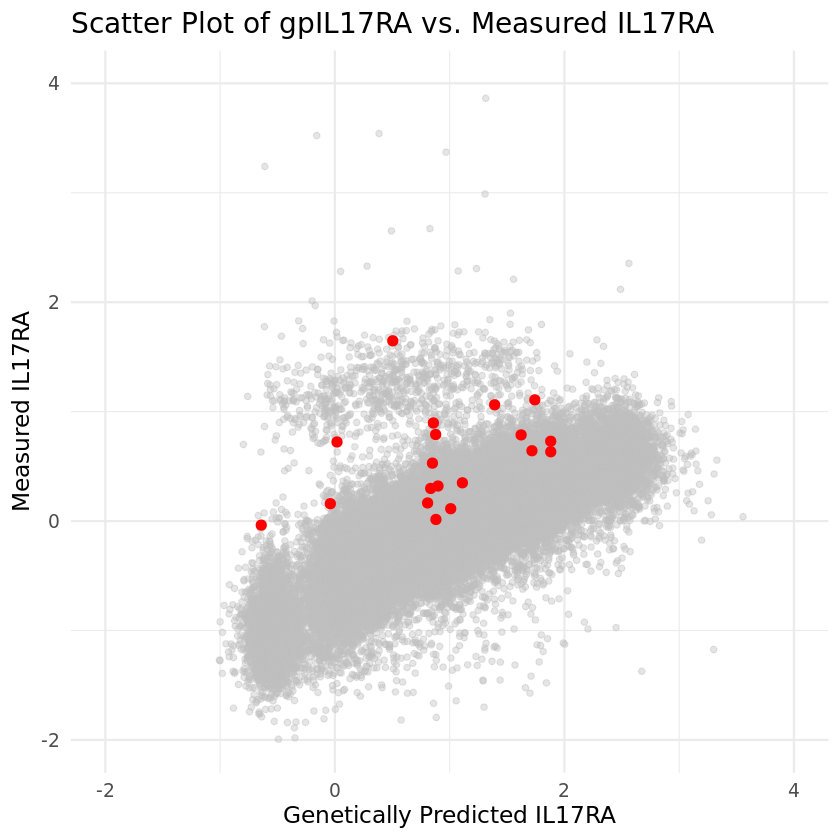

In [86]:
ggplot(data_all_pheno_cox4, aes(x = Interleukin17_receptor_A, y = il17ra)) +
  geom_point(data = subset(data_all_pheno_cox4, jak2 == 0), color = "grey", alpha = 0.4) +
  geom_point(data = subset(data_all_pheno_cox4, jak2 == 1), color = "red", size = 2.5) +
  scale_x_continuous(limits = c(-2, 4)) +
  scale_y_continuous(limits = c(-2, 4)) +
  labs(
    title = "Scatter Plot of gpIL17RA vs. Measured IL17RA",
    x = "Genetically Predicted IL17RA",
    y = "Measured IL17RA"
  ) +
  theme_minimal(base_size = 14)

## Interaction

In [71]:
data_all_pheno_cox4 <- merge(data_all_pheno_cox3, mea_il17, by.x = "ID", by.y = "eid", all = F)

In [72]:
dim(data_all_pheno_cox4)

[1] 52237  4872

In [110]:
data_filter2 <- filter(data_all_pheno_cox4,data_all_pheno_cox4$surv_CVD >0)

In [111]:
dim(data_filter2)

[1] 50720  4876

In [30]:
cox_fit <- coxph(Surv(surv_CVD,CVD)~ jak2 + il17a + il17a*jak2 +
                 baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5+ldl_0+baseline_DM+BMI_0+baseline_HTN+AID, data = data_filter2)
summary(cox_fit)

Call:
coxph(formula = Surv(surv_CVD, CVD) ~ jak2 + il17a + il17a * 
    jak2 + baseline_age + age2 + genetic_sex + smoking_0 + PC1 + 
    PC2 + PC3 + PCD4 + PC5 + ldl_0 + baseline_DM + BMI_0 + baseline_HTN + 
    AID, data = data_filter2)

  n= 46048, number of events= 1029 
   (4672 observations deleted due to missingness)

                   coef  exp(coef)   se(coef)      z Pr(>|z|)    
jak2         -0.0942032  0.9100978  2.0196509 -0.047 0.962798    
il17a         0.1851401  1.2033871  0.0570401  3.246 0.001171 ** 
baseline_age  0.0323958  1.0329263  0.0643235  0.504 0.614515    
age2          0.0002651  1.0002652  0.0005593  0.474 0.635469    
genetic_sex   0.4149533  1.5143000  0.0643945  6.444 1.16e-10 ***
smoking_0     0.2439921  1.2763342  0.0449767  5.425 5.80e-08 ***
PC1          -0.0013027  0.9986981  0.0007967 -1.635 0.101996    
PC2           0.0036060  1.0036125  0.0031169  1.157 0.247300    
PC3           0.0090486  1.0090896  0.0051973  1.741 0.081679 .  
PCD4         

## il17 to jak2

In [70]:
dim(data_all_pheno_cox4)

ERROR: Error: object 'data_all_pheno_cox4' not found


In [41]:
logistic_mca <- batch_logistic_regression(
  data = data_all_pheno_cox4,
  snp_list = c("il17a", "il17ra"),
  outcome = "jak2",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

jak2 ~ il17a + baseline_age + age2 + genetic_sex + smoking_0 + 
    PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + baseline_HTN + 
    ldl_0 + AID
<environment: 0x5a5447f817a8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


jak2 ~ il17ra + baseline_age + age2 + genetic_sex + smoking_0 + 
    PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + baseline_HTN + 
    ldl_0 + AID
<environment: 0x5a5447f817a8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
il17a,il17a,0.08525063,1.088990,0.4249492,0.473478,2.504655,8.410006e-01
il17ra,il17ra,1.87489335,6.520124,0.2929747,3.671730,11.578196,1.558796e-10


In [42]:
logistic_mca <- batch_logistic_regression(
  data = data_all_pheno_cox3,
  snp_list = c("Interleukin17_receptor_A"),
  outcome = "jak2",
  covariates = c("baseline_age", "age2", "genetic_sex", "smoking_0", "PC1","PC2","PC3","PCD4","PC5","BMI_0","baseline_DM","baseline_HTN","ldl_0","AID")
)
logistic_mca

jak2 ~ Interleukin17_receptor_A + baseline_age + age2 + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID
<environment: 0x5a54451ab1e8>


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


,SNP,Beta,OR,SE,CI_Lower,CI_Upper,P_Value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Interleukin17_receptor_A,Interleukin17_receptor_A,-0.0631698,0.9387841,0.09617523,0.7774987,1.133527,0.5112968


In [119]:
firth <- logistf(jak2 ~ il17ra + baseline_age  + genetic_sex + smoking_0
                 +PC1+PC2+PC3+PCD4+PC5+ BMI_0+baseline_DM+baseline_HTN+ldl_0+AID, data = data_all_pheno_cox4
)
summary(firth)

logistf(formula = jak2 ~ il17ra + baseline_age + genetic_sex + 
    smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5 + BMI_0 + baseline_DM + 
    baseline_HTN + ldl_0 + AID, data = data_all_pheno_cox4)

Model fitted by Penalized ML
Coefficients:
                      coef    se(coef)    lower 0.95   upper 0.95        Chisq
(Intercept)  -7.3819063179 2.084074325 -12.349093146 -2.851045591 1.063548e+01
il17ra        1.8647344244 0.249123098   1.273212914  2.385183721 2.627692e+01
baseline_age  0.0499645572 0.025863401  -0.006583192  0.112157907 2.977956e+00
genetic_sex  -0.0639455851 0.405962221  -0.996494852  0.851798127 1.895131e-02
smoking_0    -0.0355107458 0.281241404  -0.703213763  0.612178550 1.069652e-02
PC1          -0.0001059963 0.003333932  -0.020158011  0.005284667 7.959545e-04
PC2          -0.0075892309 0.004268135  -0.022097995  0.026092216 1.822023e+00
PC3           0.0083065363 0.007181639  -0.008857690  0.063807561 1.040086e+00
PCD4         -0.0041479417 0.011564511  -0.02636134

# Heme data

In [9]:
system("gsutil cp gs://bicklab-main-storage/Users/Yash_Pershad/ukb_measurement_data.csv .")

In [2]:
ukb_measure <- read.csv("ukb_measurement_data.csv")

In [47]:
names(data_all_pheno_cox3)[1] <- "person_id"

In [49]:
data_all_pheno_cox3$person_id <- as.character(data_all_pheno_cox3$person_id)

In [52]:
ukb_measure$person_id <- as.character(ukb_measure$person_id)

In [53]:
ukb_measure_all <- ukb_measure %>%
  left_join(data_all_pheno_cox3 %>% select(person_id, min_date), by = "person_id")

In [54]:
head(ukb_measure_all)

,person_id,measurement_datetime,hgb,mcv,plt,rdw,wbc,min_date
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<IDate>
1,1000024,2009-11-30 00:00:00+00:00,14.05,93.37,272.4,12.8,7.37,2009-11-30
2,1000036,2004-02-23 00:00:00+00:00,14.20,NA,135.0,NA,5.90,2008-04-12
3,1000036,2008-04-12 00:00:00+00:00,14.00,90.70,99.0,12.8,7.60,2008-04-12
4,1000036,2008-05-16 00:00:00+00:00,13.70,NA,117.0,NA,6.44,2008-04-12
5,1000036,2008-05-30 00:00:00+00:00,13.70,NA,66.0,NA,5.49,2008-04-12
6,1000036,2008-06-18 00:00:00+00:00,13.90,NA,62.0,NA,6.59,2008-04-12


In [55]:
summary_stats <- ukb_measure_all %>%
  arrange(person_id, measurement_datetime) %>%
  group_by(person_id) %>%
  summarise(
    hgb_baseline = first(hgb),
    hgb_latest   = last(hgb),
    hgb_mean     = mean(hgb, na.rm = TRUE),
    hgb_dna      = hgb[which.min(abs(difftime(measurement_datetime, min_date, units = "days")))],

    mcv_baseline = first(mcv),
    mcv_latest   = last(mcv),
    mcv_mean     = mean(mcv, na.rm = TRUE),
    mcv_dna      = mcv[which.min(abs(difftime(measurement_datetime, min_date, units = "days")))],

    plt_baseline = first(plt),
    plt_latest   = last(plt),
    plt_mean     = mean(plt, na.rm = TRUE),
    plt_dna      = plt[which.min(abs(difftime(measurement_datetime, min_date, units = "days")))],

    rdw_baseline = first(rdw),
    rdw_latest   = last(rdw),
    rdw_mean     = mean(rdw, na.rm = TRUE),
    rdw_dna      = rdw[which.min(abs(difftime(measurement_datetime, min_date, units = "days")))],

    wbc_baseline = first(wbc),
    wbc_latest   = last(wbc),
    wbc_mean     = mean(wbc, na.rm = TRUE),
    wbc_dna      = wbc[which.min(abs(difftime(measurement_datetime, min_date, units = "days")))],

    .groups = "drop"
  )

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”


In [57]:
dim(summary_stats)
head(summary_stats)

[1] 476579     21

person_id,hgb_baseline,hgb_latest,hgb_mean,hgb_dna,mcv_baseline,mcv_latest,mcv_mean,mcv_dna,plt_baseline,⋯,plt_mean,plt_dna,rdw_baseline,rdw_latest,rdw_mean,rdw_dna,wbc_baseline,wbc_latest,wbc_mean,wbc_dna
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000024,14.05,14.05,14.05000,14.05,93.37,93.37,93.37,93.37,272.4,⋯,272.4000,272.4,12.80,12.80,12.80,12.80,7.37,7.37,7.370000,7.37
1000036,14.20,13.50,13.97083,14.00,NA,NA,90.70,90.70,135.0,⋯,94.3750,99.0,NA,NA,12.80,12.80,5.90,9.58,6.227083,7.60
1000048,13.00,13.00,13.00000,13.00,83.40,83.40,83.40,83.40,256.0,⋯,256.0000,256.0,15.60,15.60,15.60,15.60,6.40,6.40,6.400000,6.40
1000055,13.98,13.98,13.98000,13.98,93.37,93.37,93.37,93.37,320.6,⋯,320.6000,320.6,12.57,12.57,12.57,12.57,8.58,8.58,8.580000,8.58
1000067,14.10,14.10,14.10000,14.10,87.80,87.80,87.80,87.80,221.0,⋯,221.0000,221.0,13.40,13.40,13.40,13.40,5.80,5.80,5.800000,5.80
1000072,12.00,13.70,13.46667,12.00,85.80,NA,85.80,85.80,290.0,⋯,266.6667,290.0,14.80,NA,14.80,14.80,6.40,6.20,6.400000,6.40


In [45]:
dim(data_all_pheno_cox3)
dim(data_all_pheno_jak)

[1] 487409   4870

[1] 471356   4876

In [17]:
table(data_all_pheno_cox3$jak2, useNA = "always")


     0      1   <NA> 
486879    192    338 

In [22]:
ukb_measure_jak2 <- filter(ukb_measure, ukb_measure$person_id %in% data_jak2_pheno$ID)
dim(ukb_measure_jak2)

[1] 758   7

In [19]:
data_jak2_pheno <- filter(data_all_pheno_cox3, data_all_pheno_cox3$jak2 == 1)
dim(data_jak2_pheno)

[1]  192 4870

In [140]:
data_all_jak_heme <- merge(data_all_pheno_jak,summary_stats,by.x = "ID", by.y = "person_id", all = F)

In [141]:
dim(data_all_jak_heme)

[1] 461176   4898

In [142]:
save(data_all_jak_heme, file = "data_all_jak_heme.Rdata")

In [10]:
x <- load("data_all_jak_heme.Rdata")
x

[1] "data_all_jak_heme"

In [4]:
blood_vars <- c("wbc_baseline", "wbc_latest", "wbc_dna", "wbc_mean",
                "hgb_baseline", "hgb_latest", "hgb_dna", "hgb_mean",
                "mcv_baseline", "mcv_latest", "mcv_dna", "mcv_mean",
                "plt_baseline", "plt_latest", "plt_dna", "plt_mean",
                "rdw_baseline", "rdw_latest", "rdw_dna", "rdw_mean")

In [11]:
blood_vars <- c("wbc_dna",
                "hgb_dna",
                "mcv_dna",
                "plt_dna",
                "rdw_dna")

In [12]:
analyze_jak2_assoc <- function(var, data) {
  formula <- as.formula(paste("jak2 ~", var, "+baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5"))
  model <- glm(formula, data = data, family = binomial)

  tidy_result <- tidy(model) %>%
    filter(term == var) %>%
    mutate(
      OR = exp(estimate),
      CI_lower = exp(estimate - 1.96 * std.error),
      CI_upper = exp(estimate + 1.96 * std.error)
    ) %>%
    select(term, OR, CI_lower, CI_upper, p.value) %>%
    rename(Variable = term, P = p.value)

  return(tidy_result)
}

In [150]:
results <- lapply(blood_vars, analyze_jak2_assoc, data = data_all_jak_heme)
results_df <- bind_rows(results)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [151]:
results_df

Variable,OR,CI_lower,CI_upper,P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hgb_baseline,1.4461437,1.2508646,1.671909,6.219761e-07
hgb_latest,0.9373439,0.8243863,1.065779,3.233372e-01
hgb_mean,1.1597572,1.0010325,1.343649,4.841097e-02
hgb_dna,1.2612924,1.0886356,1.461333,1.996805e-03
mcv_baseline,1.0779389,1.0431735,1.113863,7.222474e-06
mcv_latest,1.0918138,1.0577054,1.127022,5.809929e-08
mcv_mean,1.0952220,1.0666902,1.124517,1.440570e-11
mcv_dna,1.0952220,1.0666902,1.124517,1.440570e-11
plt_baseline,1.0119698,1.0111336,1.012807,4.222978e-175


In [13]:
results <- lapply(blood_vars, analyze_jak2_assoc, data = data_all_jak_heme)
results_df <- bind_rows(results)
results_df

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Variable,OR,CI_lower,CI_upper,P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
wbc_dna,1.045912,1.033616,1.058354,1.006486e-13
hgb_dna,1.261292,1.088636,1.461333,1.996805e-03
mcv_dna,1.095222,1.066690,1.124517,1.440570e-11
plt_dna,1.013471,1.012542,1.014402,1.081540e-179
rdw_dna,1.610574,1.552596,1.670717,3.366696e-143


In [21]:
results_df$P_Bonferroni <- p.adjust(results_df$P, method = "fdr")
results_df

Variable,OR,CI_lower,CI_upper,P,P_Bonferroni
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wbc_dna,1.045912,1.033616,1.058354,1.006486e-13,1.677477e-13
hgb_dna,1.261292,1.088636,1.461333,1.996805e-03,1.996805e-03
mcv_dna,1.095222,1.066690,1.124517,1.440570e-11,1.800713e-11
plt_dna,1.013471,1.012542,1.014402,1.081540e-179,5.407698e-179
rdw_dna,1.610574,1.552596,1.670717,3.366696e-143,8.416740e-143


In [152]:
jak2_heme <- filter(data_all_jak_heme, data_all_jak_heme$jak2 == 1)
dim(jak2_heme)

[1]  186 4898

In [156]:
analyze_il17ra_assoc <- function(var, data) {
  formula <- as.formula(paste("Interleukin17_receptor_A ~", var, 
                              "+ baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5"))
  
  model <- lm(formula, data = data)

  tidy_result <- tidy(model) %>%
    filter(term == var) %>%
    mutate(
      CI_lower = estimate - 1.96 * std.error,
      CI_upper = estimate + 1.96 * std.error
    ) %>%
    select(term, estimate, CI_lower, CI_upper, p.value) %>%
    rename(Variable = term, Beta = estimate, P = p.value)

  return(tidy_result)
}

In [157]:
results_jak2 <- lapply(blood_vars, analyze_il17ra_assoc, data = jak2_heme)
results_jak2 <- bind_rows(results_jak2)

In [158]:
results_jak2

Variable,Beta,CI_lower,CI_upper,P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hgb_baseline,-1.135149e-02,-0.0674309064,0.0447279247,0.6920429
hgb_latest,2.651687e-02,-0.0285329431,0.0815666765,0.3464152
hgb_mean,5.480474e-03,-0.0568677511,0.0678286985,0.8634117
hgb_dna,-7.308665e-03,-0.0687963200,0.0541789900,0.8160544
mcv_baseline,-3.110886e-03,-0.0135495308,0.0073277591,0.5601651
mcv_latest,-4.314268e-03,-0.0154167065,0.0067881710,0.4478667
mcv_mean,-1.733901e-03,-0.0105195642,0.0070517621,0.6993669
mcv_dna,-1.733901e-03,-0.0105195642,0.0070517621,0.6993669
plt_baseline,-4.131788e-05,-0.0006172112,0.0005345755,0.8883306


In [159]:
results_il17all <- lapply(blood_vars, analyze_il17ra_assoc, data = data_all_jak_heme)
results_il17all <- bind_rows(results_il17all)

In [160]:
results_il17all

Variable,Beta,CI_lower,CI_upper,P
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hgb_baseline,-2.158482e-03,-4.348304e-03,3.134000e-05,0.05336640
hgb_latest,-1.115235e-03,-3.285630e-03,1.055159e-03,0.31387453
hgb_mean,-1.828389e-03,-4.144532e-03,4.877529e-04,0.12180448
hgb_dna,-2.002734e-03,-4.282694e-03,2.772247e-04,0.08512822
mcv_baseline,-1.077211e-04,-6.696387e-04,4.541965e-04,0.70711253
mcv_latest,-1.245143e-04,-7.160938e-04,4.670653e-04,0.67994674
mcv_mean,-1.297770e-04,-6.405794e-04,3.810253e-04,0.61850721
mcv_dna,-1.297770e-04,-6.405794e-04,3.810253e-04,0.61850721
plt_baseline,-2.364521e-06,-4.031554e-05,3.558650e-05,0.90280648


In [16]:
library(dplyr)
library(broom)

analyze_interaction <- function(var, data) {
  formula_str <- paste(var, "~ Interleukin17_receptor_A * jak2 + baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + PC3 + PCD4 + PC5")
  model <- lm(as.formula(formula_str), data = data)

  tidy_result <- tidy(model) %>%
    filter(term == "Interleukin17_receptor_A:jak2") %>%
    mutate(
      CI_lower = estimate - 1.96 * std.error,
      CI_upper = estimate + 1.96 * std.error
    ) %>%
    select(term, estimate, CI_lower, CI_upper, p.value) %>%
    rename(
      Variable = term,
      Beta = estimate,
      P = p.value
    ) %>%
    mutate(Blood_Measure = var) %>%
    select(Blood_Measure, everything())

  return(tidy_result)
}

In [17]:
interaction_results <- lapply(blood_vars, analyze_interaction, data = data_all_jak_heme)
interaction_summary <- bind_rows(interaction_results)

In [183]:
interaction_summary

Blood_Measure,Variable,Beta,CI_lower,CI_upper,P
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hgb_baseline,Interleukin17_receptor_A:jak2,-0.11769768,-0.31332274,0.07792738,0.238306168
hgb_latest,Interleukin17_receptor_A:jak2,0.07989188,-0.11748994,0.27727370,0.427588447
hgb_mean,Interleukin17_receptor_A:jak2,-0.04218524,-0.22714562,0.14277514,0.654852711
hgb_dna,Interleukin17_receptor_A:jak2,-0.09647871,-0.28437296,0.09141554,0.314219870
mcv_baseline,Interleukin17_receptor_A:jak2,-1.13985126,-2.09912581,-0.18057672,0.019861906
mcv_latest,Interleukin17_receptor_A:jak2,-1.50051666,-2.49694426,-0.50408906,0.003161978
mcv_mean,Interleukin17_receptor_A:jak2,-0.61338963,-1.46403589,0.23725662,0.157559466
mcv_dna,Interleukin17_receptor_A:jak2,-0.61338963,-1.46403589,0.23725662,0.157559466
plt_baseline,Interleukin17_receptor_A:jak2,-1.33784607,-12.60460580,9.92891366,0.815966674


In [20]:
interaction_summary$P_Bonferroni <- p.adjust(interaction_summary$P, method = "fdr")
interaction_summary

Blood_Measure,Variable,Beta,CI_lower,CI_upper,P,P_Bonferroni
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
wbc_dna,Interleukin17_receptor_A:jak2,0.34448641,-0.03241935,0.72139216,0.073227921,0.18306980
hgb_dna,Interleukin17_receptor_A:jak2,-0.09647871,-0.28437296,0.09141554,0.314219870,0.31421987
mcv_dna,Interleukin17_receptor_A:jak2,-0.61338963,-1.46403589,0.23725662,0.157559466,0.26259911
plt_dna,Interleukin17_receptor_A:jak2,6.09382061,-4.88083166,17.06847289,0.276456250,0.31421987
rdw_dna,Interleukin17_receptor_A:jak2,-0.26962433,-0.45548967,-0.08375899,0.004465645,0.02232823


In [ ]:
#impuation of missing data by mean

In [6]:
summary(data_all_jak_heme$mcv_dna)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  52.10   88.53   91.20   91.11   93.89  160.30    4245 

In [171]:
data_all_jak_heme2 <- data_all_jak_heme %>%
  mutate(across(all_of(blood_vars), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .)))

In [186]:
summary(data_all_jak_heme2$plt_dna)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.4   213.3   248.0   253.1   287.0  1821.0 

In [173]:
interaction_results <- lapply(blood_vars, analyze_interaction, data = data_all_jak_heme2)
interaction_summary <- bind_rows(interaction_results)
interaction_summary

Blood_Measure,Variable,Beta,CI_lower,CI_upper,P
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hgb_baseline,Interleukin17_receptor_A:jak2,-0.11769768,-0.31332274,0.07792738,0.238306168
hgb_latest,Interleukin17_receptor_A:jak2,0.07989188,-0.11748994,0.27727370,0.427588447
hgb_mean,Interleukin17_receptor_A:jak2,-0.04218524,-0.22714562,0.14277514,0.654852711
hgb_dna,Interleukin17_receptor_A:jak2,-0.09647871,-0.28437296,0.09141554,0.314219870
mcv_baseline,Interleukin17_receptor_A:jak2,-0.80979722,-1.57725873,-0.04233571,0.038629291
mcv_latest,Interleukin17_receptor_A:jak2,-1.09673670,-1.82787007,-0.36560334,0.003281245
mcv_mean,Interleukin17_receptor_A:jak2,-0.56949839,-1.40844904,0.26945226,0.183356993
mcv_dna,Interleukin17_receptor_A:jak2,-0.56949839,-1.40844904,0.26945226,0.183356993
plt_baseline,Interleukin17_receptor_A:jak2,-1.33784607,-12.60460580,9.92891366,0.815966674


In [187]:
# Thrombocytoses

In [188]:
data_all_jak_heme$thromb_dna <- NA
data_all_jak_heme$thromb_dna <- ifelse(data_all_jak_heme$plt_dna >450, 1, 0)

In [192]:
results_thromb <- glm(thromb_dna~ jak2*Interleukin17_receptor_A+baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5, data = data_all_jak_heme, family = binomial)

In [194]:
summary(results_thromb)


Call:
glm(formula = thromb_dna ~ jak2 * Interleukin17_receptor_A + 
    baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + 
    PC3 + PCD4 + PC5, family = binomial, data = data_all_jak_heme)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.1792499  0.9885120  -4.228 2.36e-05 ***
jak2                           5.0393890  0.2463230  20.458  < 2e-16 ***
Interleukin17_receptor_A      -0.0203973  0.0266217  -0.766   0.4436    
baseline_age                  -0.0211076  0.0365227  -0.578   0.5633    
age2                           0.0000921  0.0003320   0.277   0.7815    
genetic_sex                   -0.8981756  0.0469954 -19.112  < 2e-16 ***
smoking_0                      0.1975745  0.0288019   6.860 6.90e-12 ***
PC1                           -0.0003823  0.0004208  -0.909   0.3636    
PC2                           -0.0006216  0.0008789  -0.707   0.4794    
PC3                            0.0064191  0.0015225   

In [10]:
data_all_jak_heme$thromb_latest <- NA
data_all_jak_heme$thromb_latest <- ifelse(data_all_jak_heme$plt_latest >450, 1, 0)

In [13]:
results_thromb <- glm(thromb_latest~ jak2*Interleukin17_receptor_A+baseline_age+age2+genetic_sex+smoking_0+PC1+PC2+PC3+PCD4+PC5 +baseline_DM+ BMI_0+baseline_HTN+ ldl_0, data = data_all_jak_heme, family = binomial)
summary(results_thromb)


Call:
glm(formula = thromb_latest ~ jak2 * Interleukin17_receptor_A + 
    baseline_age + age2 + genetic_sex + smoking_0 + PC1 + PC2 + 
    PC3 + PCD4 + PC5 + baseline_DM + BMI_0 + baseline_HTN + ldl_0, 
    family = binomial, data = data_all_jak_heme)

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.0288796  0.9197202  -4.381 1.18e-05 ***
jak2                           4.4920457  0.2626298  17.104  < 2e-16 ***
Interleukin17_receptor_A      -0.0187689  0.0243516  -0.771 0.440858    
baseline_age                  -0.0342776  0.0338815  -1.012 0.311685    
age2                           0.0002939  0.0003060   0.961 0.336749    
genetic_sex                   -0.7099798  0.0414275 -17.138  < 2e-16 ***
smoking_0                      0.2651918  0.0262836  10.090  < 2e-16 ***
PC1                           -0.0004167  0.0003854  -1.081 0.279676    
PC2                           -0.0002988  0.0007988  -0.374 0.708368    
P